In [1]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}",
    "font.family": "Time New Roman",
    "font.size": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

import copy
import heapq
import os
if not os.path.exists('fig'):
    os.makedirs('fig')


from Solver import Ginzburg_Landau_type_Solver as gl_solver

In [2]:
def find_nearest(array, value):
    '''
    Get the index of the nearest value in an array
    '''
    idx = (np.abs(array - value)).argmin()
    return idx


def get_smaller_from_list(my_list: list, n=1): 
    """
    Get the n smallest number from a list, 
    and return the index of the smallest number in the original list.
    """ 
    my_list = copy.deepcopy(my_list)
    smaller_number: list = heapq.nsmallest(n, my_list) 
    smaller_index = []
    for sn in smaller_number:
        index = find_nearest(my_list,sn) 
        smaller_index.append(index)
        my_list[index] = float("inf")
    return smaller_number, smaller_index 

def add_right_cax(ax, pad, width, pad_y = 0, height = 0):
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
    axpos.x1 + pad,
    axpos.y0 + pad_y,
    axpos.x1 + pad + width,
    axpos.y1 + pad_y + height) 
    cax = ax.figure.add_axes(caxpos)
    return cax

# Linear stability region

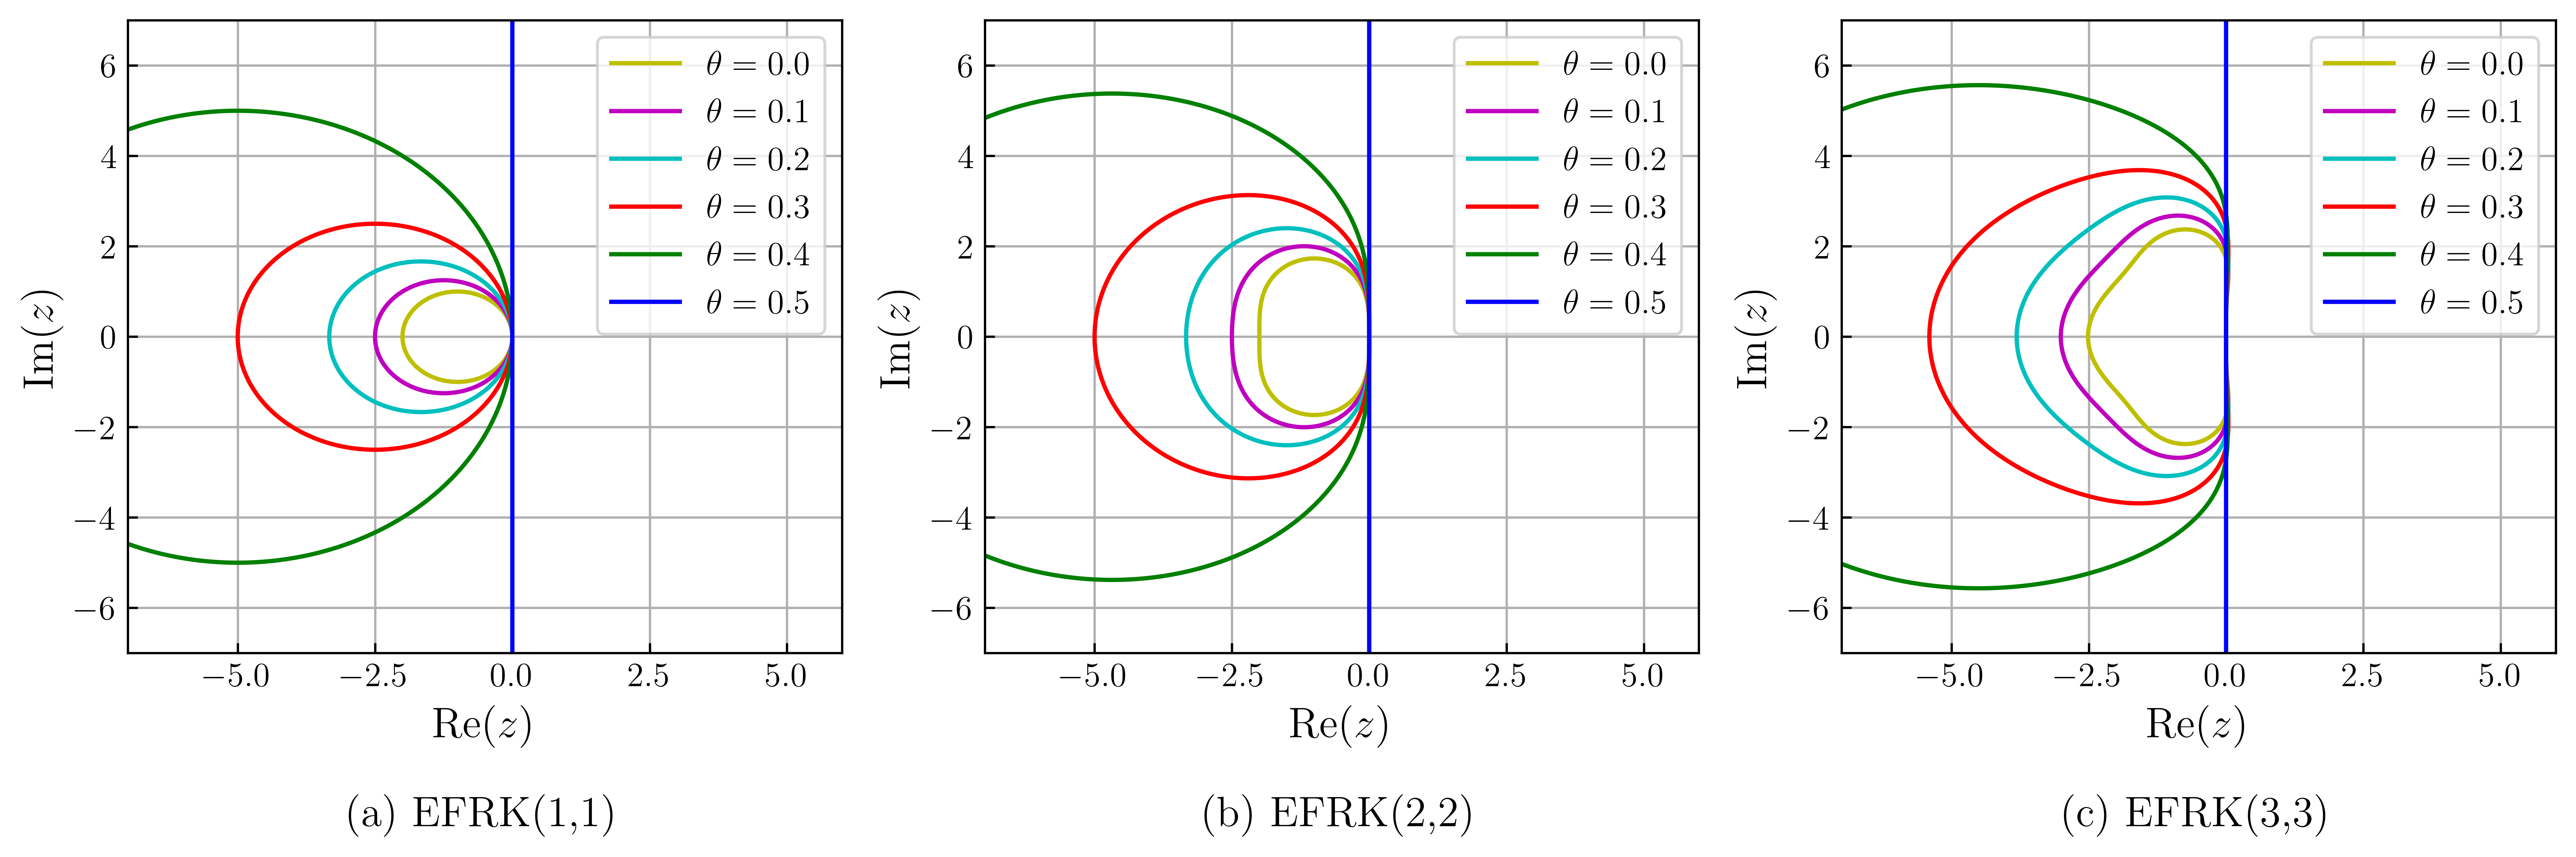

In [5]:
X,Y = np.meshgrid(np.linspace(-7,6,1300),np.linspace(-8,8,1400))
lams = [0.0,0.1,0.2,0.3,0.4,0.5]
color = ["y","m","c","r","g","b"]

psi = [
    lambda x:1+x,
    lambda x:1+x+x**2/2,
    lambda x:1+x+x**2/2+x**3/6,
    lambda x:1+x+x**2/2+x**3/6+x**4/24,
    lambda x:1+x+0.5*x**2 + 0.1667*x**3 + 0.04167*x**4 + 0.004507*x**5
]

titles = [
    r"(a) EFRK${}$(1,1)",
    r"(b) EFRK${}$(2,2)",
    r"(c) EFRK${}$(3,3)",
    r"(d) EFRK${}$(4,4)",
    r"(e) EFRK${}$(5,4)",
]


fig = plt.figure(figsize=(26,4),dpi=600)
for j in range(3):
    ax = plt.subplot(1,5,j+1)
    for i,lam in enumerate(lams):
        Z = psi[j]((1-lam)*(X+1j*Y))/psi[j](-lam*(X+1j*Y))
        Z = np.abs(Z)
        plt.plot([0],[0],color[i],label=rf"$\theta={lam}$")
        cs = ax.contour(X,Y,Z,[1,],colors = color[i])
    if j < 4:
        ax.set_ylim(-7,7)
    ax.legend(fontsize="12")
    ax.set_title(titles[j],fontdict={'family': 'serif','weight': 'normal','size': 15},y=-0.3)
    ax.set_xlabel(r"Re$(z)$",fontsize = 15)
    ax.set_ylabel(r"Im$(z)$",fontsize = 15)
    ax.grid()
fig.subplots_adjust(wspace=0.2)

fig.savefig("fig/stability_region.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

In [4]:
s_domain = (-np.pi,-np.pi,np.pi,np.pi)
discrete_num = [128,128]
xn = np.linspace(s_domain[0],s_domain[2],discrete_num[0]+1)
yn = np.linspace(s_domain[1],s_domain[3],discrete_num[1]+1)
X,Y = np.meshgrid(xn,yn)
initial_condition = 0.1*(np.sin(3*X)*np.cos(2*Y))


gf_type = "Hm1"
kappa = 0
delta = 0.1
t_period = [0,delta*10]

def err_test(eps_sq,start,end,step_method,ref_solution):
    err = []
    for i in range(start,end+1):
        solver = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,step_method)
        solver.solve(t_period,2**-i*delta)
        err.append(np.sqrt(np.mean(np.square(solver.Un[-1] - ref_solution[-1]))))
    return err

### $\varepsilon = 0.1$

In [ ]:
eps_sq = 0.1

tau_ref = 2**-11*delta
solver_ref = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
solver_ref.solve(t_period,tau_ref)

start,end = 0,8

# step_method = "EFRK1"
# print(step_method)
# err_efrk1_01 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

# step_method = "ERK2"
# print(step_method)
# err_efrk2_01 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "ETDRK3"
print(step_method)
err_efrk3_01 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

In [ ]:
plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk3_01,"y-",marker = "s",label="EFRK(3,3)")
plt.plot([delta*2**-i for i in range(start,end+1)],[1e-6*8**-i for i in range(start,end+1)],"k:",label="3rd order")

plt.xscale("log")
plt.yscale("log")

### $\varepsilon = 0.01$

In [ ]:
eps_sq = 0.01

tau_ref = 2**-11*delta
solver_ref = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
solver_ref.solve(t_period,tau_ref)

start,end = 0,8

step_method = "EFRK1"
print(step_method)
err_efrk1_001 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "ERK2"
print(step_method)
err_efrk2_001 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "ERK3"
print(step_method)
err_efrk3_001 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

In [ ]:
fig = plt.figure(figsize=(11,4.5),dpi=150)

plt.subplot(1,2,1)
plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk1_01,"r-",marker="o",label="EFRK(1,1)")
plt.plot([delta*2**-i for i in range(start,end+1)],[0.3e-3*2**-i for i in range(start,end+1)],"k--",label="1st order")

plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk2_01,"b-",marker = "o",fillstyle ="none",label="EFRK(2,2)")
plt.plot([delta*2**-i for i in range(start,end+1)],[0.7e-5*4**-i for i in range(start,end+1)],"k-.",label="2nd order")

plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk3_01,"y-",marker = "s",label="EFRK(3,3)")
plt.plot([delta*2**-i for i in range(start,end+1)],[1e-6*8**-i for i in range(start,end+1)],"k:",label="3rd order")

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-5,1e-2)
# plt.ylim(1e-11,5e-2)
plt.legend(loc="lower right")

plt.ylabel(r"$L^{2}$ norm error",fontsize = 12)
plt.xlabel("time step size",fontsize = 12)
plt.title(r"(a) $\varepsilon^2 = 0.1$",y = -.25,fontsize = 15)

plt.subplot(1,2,2)
plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk1_001,"r-",marker="o",label="EFRK(1,1)")
plt.plot([delta*2**-i for i in range(start,end+1)],[0.5e-2*2**-i for i in range(start,end+1)],"k--",label="1st order")

plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk2_001,"b-",marker = "o",fillstyle ="none",label="EFRK(2,2)")
plt.plot([delta*2**-i for i in range(start,end+1)],[0.5e-3*4**-i for i in range(start,end+1)],"k-.",label="2nd order")

plt.plot([delta*2**-i for i in range(start,end+1)],err_efrk3_001,"y-",marker = "s",label="EFRK(3,3)")
plt.plot([delta*2**-i for i in range(start,end+1)],[1e-4*8**-i for i in range(start,end+1)],"k:",label="3rd order")

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-5,1e-2)
# plt.ylim(1e-11,5e-2)
plt.legend(loc="lower right")

plt.ylabel(r"$L^{2}$ norm error",fontsize = 12)
plt.xlabel("time step size",fontsize = 12)
plt.title(r"(b) $\varepsilon^2 = 0.01$",y = -.25,fontsize = 15)

plt.show()

# Equilibria preservation 

In [14]:
eps = 0.02

t_period = [0,0.2]
s_domain = (-1,1)
N = 2048
discrete_num = [N]
gf_type = "Hm1"

xn = np.linspace(s_domain[0],s_domain[1],N+1)
initial_condition = np.tanh((0.5-np.abs(xn))/(np.sqrt(2)*eps))

kap = 0

In [25]:
ch_solver_lt = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="Lie_Trotter")
ch_solver_lt.solve(t_period,1e-4)

ch_solver_ssa = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="StrangSplitting")
ch_solver_ssa.solve(t_period,5e-4)

ch_solver_ifrk1 = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="IFRK1") 
ch_solver_ifrk1.solve(t_period,5e-4)

ch_solver_ifrk2 = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="IFRK2") 
ch_solver_ifrk2.solve(t_period,5e-4)

ch_solver_ifrk3 = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="IFRK3_Heun") 
ch_solver_ifrk3.solve(t_period,5e-4)

ch_solver_eifrk1 = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="EFRK1") 
ch_solver_eifrk1.solve(t_period,5e-4)

ch_solver_eifrk2 = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="EFRK2") 
ch_solver_eifrk2.solve(t_period,5e-4)

ch_solver_eifrk3 = gl_solver(gf_type,eps**2,kap,s_domain,discrete_num,initial_condition,step_method="EFRK3_Heun") 
ch_solver_eifrk3.solve(t_period,5e-4)

 0.20\0.2, Elapse: 0.000 s, Energy:0.1000, Mass:0.0000, Maximum:1.00          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0388, Mass:0.0000, Maximum:1.01          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0394, Mass:0.0000, Maximum:1.02          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0517, Mass:0.0000, Maximum:1.05          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0380, Mass:0.0000, Maximum:1.00          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0377, Mass:0.0000, Maximum:1.00          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0377, Mass:0.0000, Maximum:1.00          
 0.20\0.2, Elapse: 0.000 s, Energy:0.0377, Mass:0.0000, Maximum:1.00          


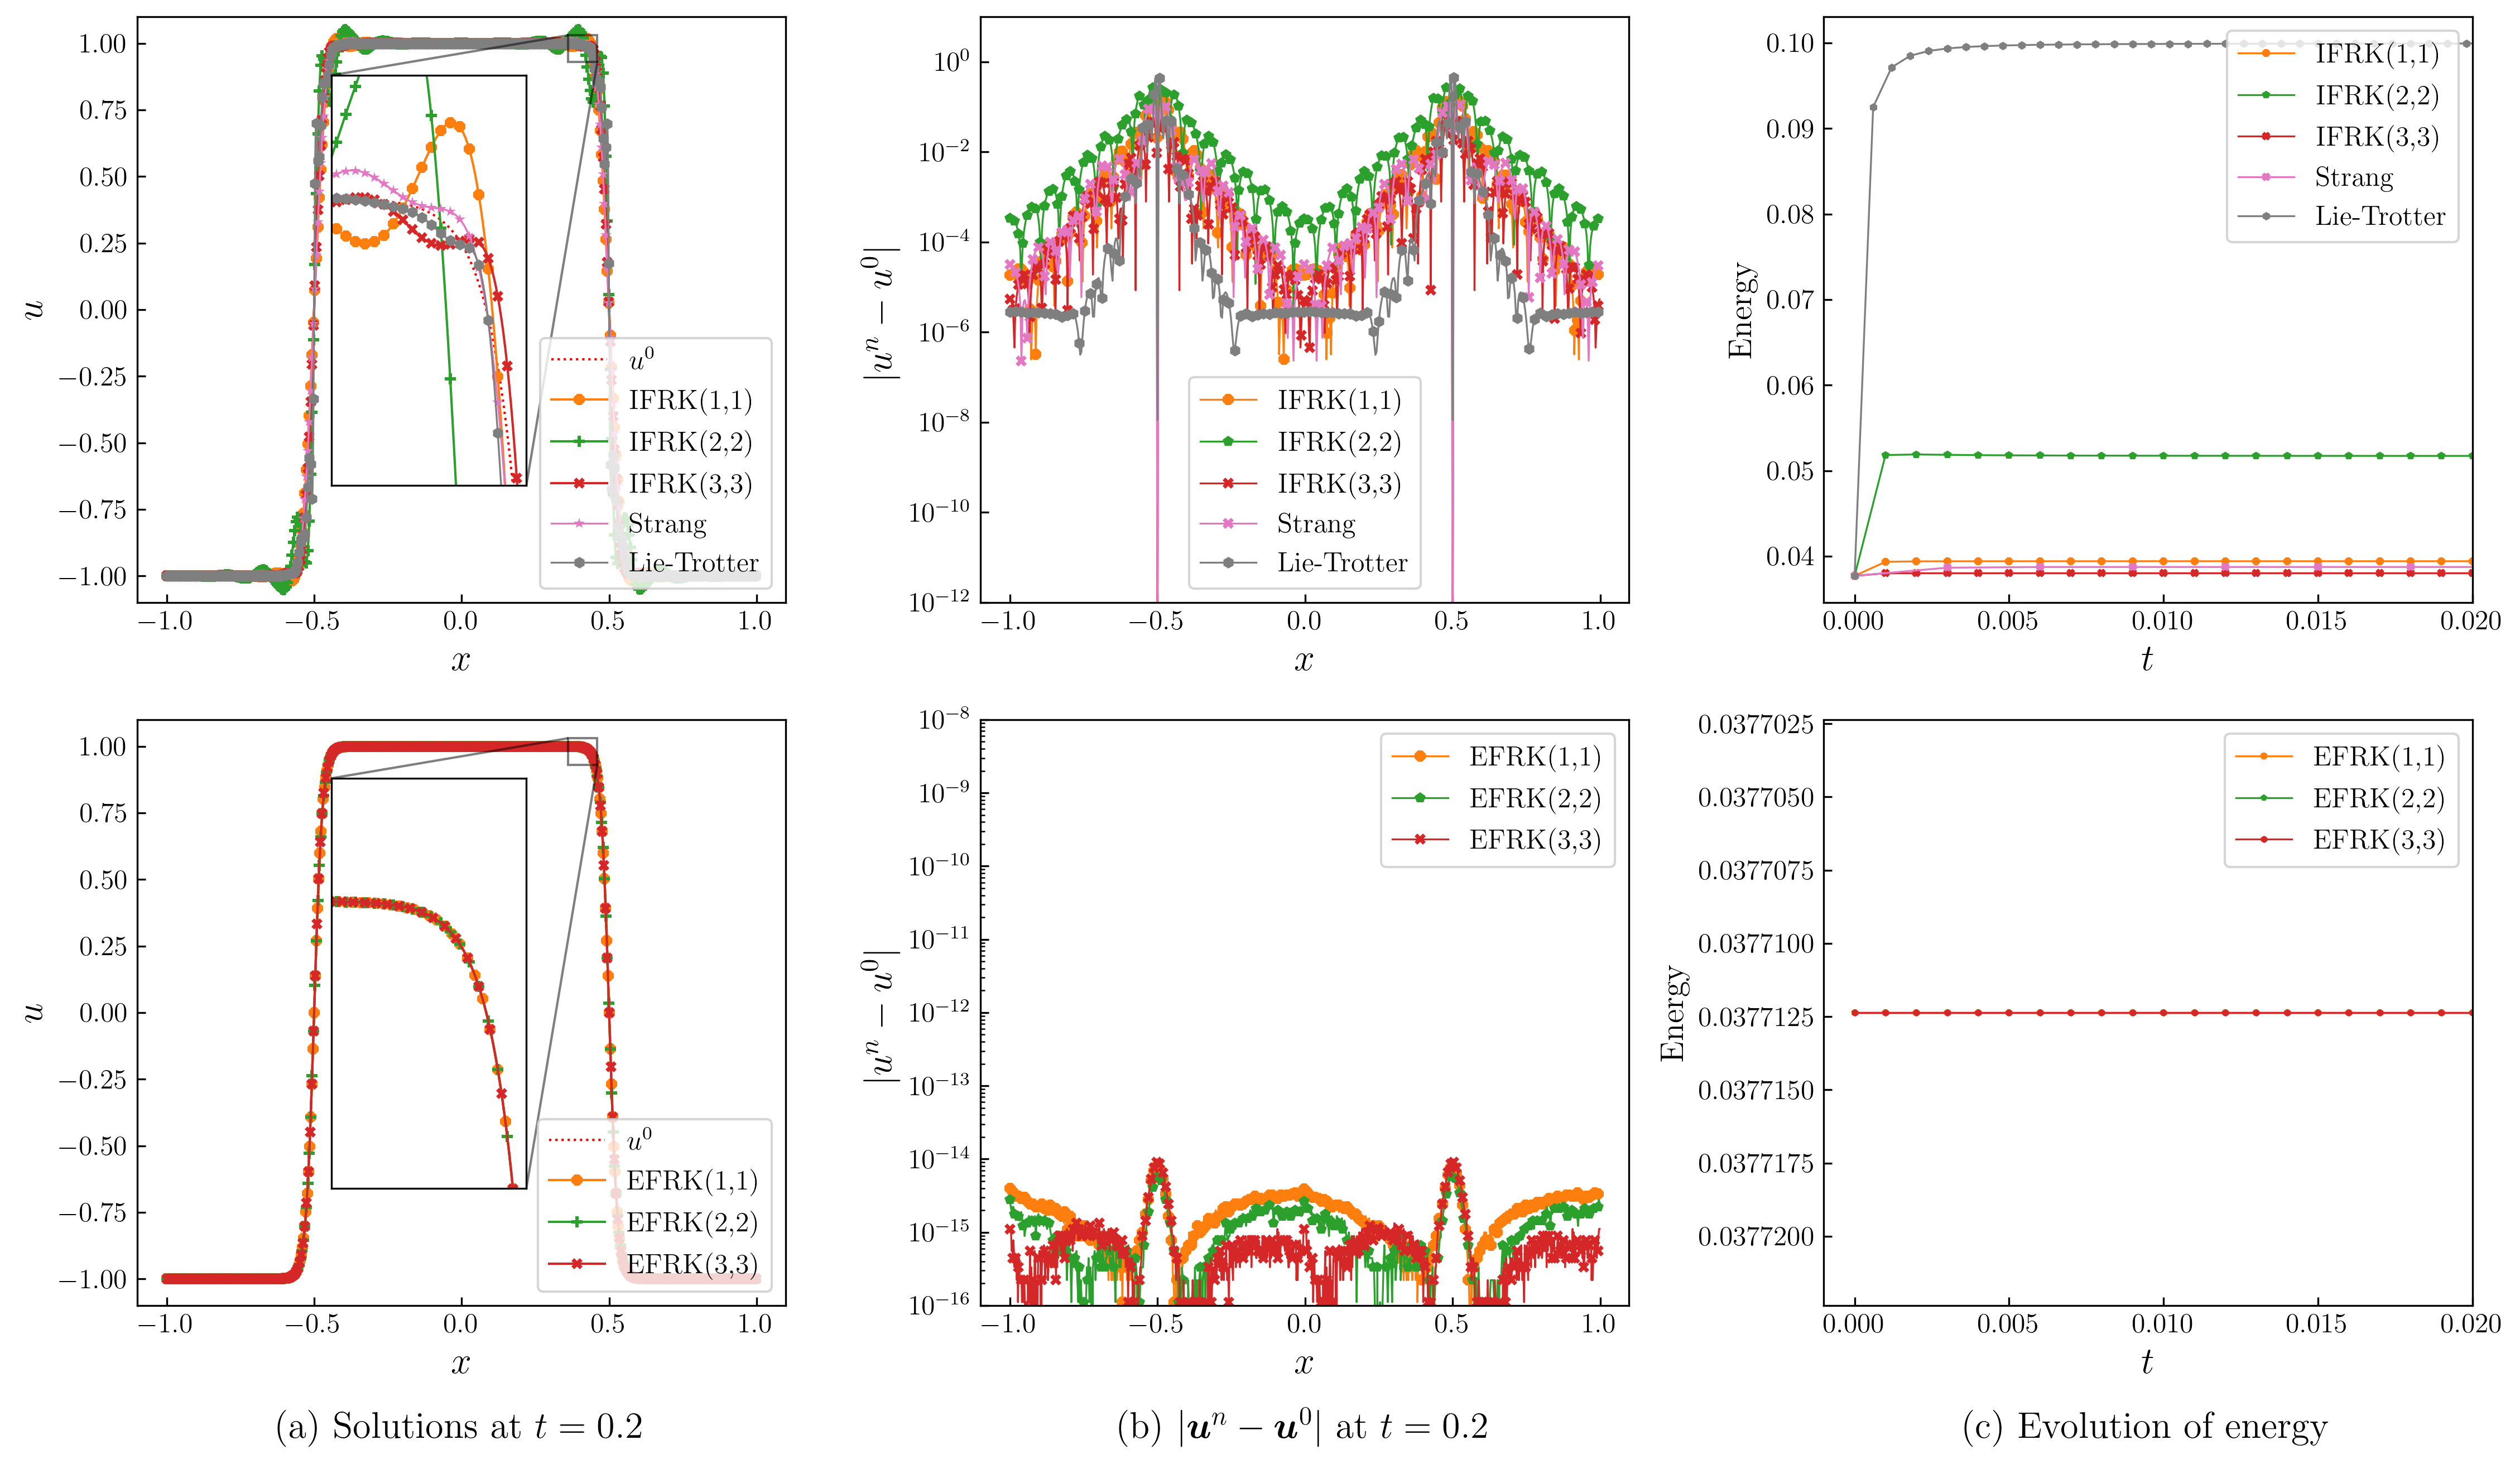

In [26]:
fig = plt.figure(figsize = (18,10),dpi = 300)

ax = plt.subplot(2,3,1)
ax.plot(xn[:-1],initial_condition[:-1],"r:",linewidth=1,label=r"$u^0$")
ax.plot(ch_solver_ifrk1.xn[:-1],ch_solver_ifrk1.Un[-1],linewidth=1,  color="C1",marker="8",markersize=5,markevery = 5,markeredgewidth = 0,label=r"IFRK${}$(1,1)")
ax.plot(ch_solver_ifrk2.xn[:-1],ch_solver_ifrk2.Un[-1],linewidth=1,  color="C2",marker="P",markersize=5,markevery = 5,markeredgewidth = 0,label=r"IFRK${}$(2,2)")
ax.plot(ch_solver_ifrk3.xn[:-1],ch_solver_ifrk3.Un[-1],linewidth=1,  color="C3",marker="X",markersize=5,markevery = 5,markeredgewidth = 0,label=r"IFRK${}$(3,3)")
ax.plot(  ch_solver_ssa.xn[:-1],  ch_solver_ssa.Un[-1],linewidth=0.8,color="C6",marker="*",markersize=5,markevery = 5,markeredgewidth = 0,label=r"Strang")
ax.plot(  ch_solver_lt.xn[:-1],  ch_solver_lt.Un[-1],linewidth=0.8,color="C7",marker="h",markersize=5,markevery = 5,markeredgewidth = 0,label=r"Lie-Trotter")

ax.legend(loc = "lower right")
ax.set_ylim(-1.1,1.1)
ax.set_xlabel("$x$",fontsize = 16)
ax.set_ylabel(r"$u$",fontsize = 16)
# ax.set_title("(b) Solutions at $t = 0.2$",fontdict={'family': 'serif','weight': 'normal','size': 16},y=-0.25)

axins = ax.inset_axes([0.30,0.2,0.3,0.7])
axins.plot(xn[:-1],initial_condition[:-1],"r:",linewidth=1)
axins.plot(ch_solver_ifrk1.xn[:-1],ch_solver_ifrk1.Un[-1],linewidth=1,color="C1",  marker="8",markersize=5,markevery = 5,markeredgewidth=0)
axins.plot(ch_solver_ifrk2.xn[:-1],ch_solver_ifrk2.Un[-1],linewidth=1,color="C2",  marker="P",markersize=5,markevery = 5,markeredgewidth=0)
axins.plot(ch_solver_ifrk3.xn[:-1],ch_solver_ifrk3.Un[-1],linewidth=1,color="C3",  marker="X",markersize=5,markevery = 5,markeredgewidth=0)
axins.plot(ch_solver_ssa.xn[:-1],ch_solver_ssa.Un[-1],linewidth=0.8,color="C6",marker="*",markersize=5,markevery = 5,markeredgewidth=0)
axins.plot(ch_solver_lt.xn[:-1],ch_solver_lt.Un[-1],linewidth=0.8,color="C7",marker="h",markersize=5,markevery = 5,markeredgewidth=0)
axins.set_xlim(0.36,0.46)
axins.set_ylim(0.93,1.03)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(2,3,2)
ax.plot(ch_solver_ifrk1.xn[:-1][::2], np.abs(initial_condition[:-1][::2]-ch_solver_ifrk1.Un[-1][::2]),marker="8",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C1",label=r"IFRK${}$(1,1)")
ax.plot(ch_solver_ifrk2.xn[:-1][::3], np.abs(initial_condition[:-1][::3]-ch_solver_ifrk2.Un[-1][::3]),marker="p",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C2",label=r"IFRK${}$(2,2)")
ax.plot(ch_solver_ifrk3.xn[:-1][::2], np.abs(initial_condition[:-1][::2]-ch_solver_ifrk3.Un[-1][::2]),marker="X",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C3",label=r"IFRK${}$(3,3)")
ax.plot(  ch_solver_ssa.xn[:-1][::4], np.abs(initial_condition[:-1][::4]-  ch_solver_ssa.Un[-1][::4]),marker="X",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C6",label=r"Strang")
ax.plot(  ch_solver_lt.xn[:-1][::4], np.abs(initial_condition[:-1][::4]-  ch_solver_lt.Un[-1][::4]),marker="h",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C7",label=r"Lie-Trotter")
ax.set_yscale("log")
ax.set_ylim(1e-12,10)
ax.legend()
ax.set_xlabel("$x$",fontsize = 16)
ax.set_ylabel(r"$|u^n - u^0|$",fontsize = 16)
# ax.set_title(r"(c) $|\boldsymbol{u}^n - \boldsymbol{u}^0|$ at $t = 0.2$",fontdict={'family': 'serif','weight': 'normal','size': 16},y=-0.25)

ax = plt.subplot(2,3,3)
ax.plot(ch_solver_ifrk1.tn[::2], ch_solver_ifrk1.En[::2],marker="8",linewidth = 0.8,markersize=2.5,color="C1",label=r"IFRK${}$(1,1)")
ax.plot(ch_solver_ifrk2.tn[::2], ch_solver_ifrk2.En[::2],marker="p",linewidth = 0.8,markersize=2.5,color="C2",label=r"IFRK${}$(2,2)")
ax.plot(ch_solver_ifrk3.tn[::2], ch_solver_ifrk3.En[::2],marker="X",linewidth = 0.8,markersize=2.5,color="C3",label=r"IFRK${}$(3,3)")
ax.plot(ch_solver_ssa.tn[::6]  , ch_solver_ssa.En[::6]  ,marker="X",linewidth = 0.8,markersize=2.5,color="C6",label=r"Strang")
ax.plot(ch_solver_lt.tn[::6]   , ch_solver_lt.En[::6]   ,marker="h",linewidth = 0.8,markersize=2.5,color="C7",label=r"Lie-Trotter")
ax.set_xlim(-0.001,0.02)
ax.set_xlabel("$t$",fontsize = 16)
ax.set_ylabel("Energy",fontsize = 14)
ax.legend(loc="upper right")
# ax.set_title("(a) Amplitude spectrum of the solutions",fontdict={'family': 'serif','weight': 'normal','size': 16} ,y=-0.25)

ax = plt.subplot(2,3,4)
ax.plot(xn[:-1],initial_condition[:-1],"r:",linewidth=1,label=r"$u^0$")
ax.plot(ch_solver_eifrk1.xn[:-1],ch_solver_eifrk1.Un[-1],linewidth=1,  color="C1",marker="8",markersize=5,markevery = 4,markeredgewidth = 0,label=r"EFRK${}$(1,1)")
ax.plot(ch_solver_eifrk2.xn[:-1],ch_solver_eifrk2.Un[-1],linewidth=1,  color="C2",marker="P",markersize=5,markevery = 5,markeredgewidth = 0,label=r"EFRK${}$(2,2)")
ax.plot(ch_solver_eifrk3.xn[:-1],ch_solver_eifrk3.Un[-1],linewidth=1,  color="C3",marker="X",markersize=5,markevery = 6,markeredgewidth = 0,label=r"EFRK${}$(3,3)")

ax.legend(loc = "lower right")
ax.set_ylim(-1.1,1.1)
ax.set_xlabel("$x$",fontsize = 16)
ax.set_ylabel(r"$u$",fontsize = 16)
ax.set_title(r"(a) Solutions at $t = 0.2$",fontdict={'family': 'serif','weight': 'normal','size': 16} ,y=-0.25)

axins = ax.inset_axes([0.30,0.2,0.3,0.7])
axins.plot(xn[:-1],initial_condition[:-1],"r:",linewidth=1)
axins.plot(ch_solver_eifrk1.xn[:-1],ch_solver_eifrk1.Un[-1],linewidth=1,color="C1",  marker="8",markersize=5,markevery = 4,markeredgewidth=0)
axins.plot(ch_solver_eifrk2.xn[:-1],ch_solver_eifrk2.Un[-1],linewidth=1,color="C2",  marker="P",markersize=5,markevery = 5,markeredgewidth=0)
axins.plot(ch_solver_eifrk3.xn[:-1],ch_solver_eifrk3.Un[-1],linewidth=1,color="C3",  marker="X",markersize=5,markevery = 6,markeredgewidth=0)
axins.set_xlim(0.36,0.46)
axins.set_ylim(0.93,1.03)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(2,3,5)
ax.plot(ch_solver_eifrk1.xn[:-1][::2], np.abs(initial_condition[:-1][::2]-ch_solver_eifrk1.Un[-1][::2]),marker="8",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C1",label=r"EFRK${}$(1,1)")
ax.plot(ch_solver_eifrk2.xn[:-1][::3], np.abs(initial_condition[:-1][::3]-ch_solver_eifrk2.Un[-1][::3]),marker="p",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C2",label=r"EFRK${}$(2,2)")
ax.plot(ch_solver_eifrk3.xn[:-1][::2], np.abs(initial_condition[:-1][::2]-ch_solver_eifrk3.Un[-1][::2]),marker="X",linewidth = 0.8,markersize=5,markevery = 5,markeredgewidth=0,color="C3",label=r"EFRK${}$(3,3)")
ax.set_yscale("log")
ax.set_ylim(1e-16,1e-8)
ax.legend()
ax.set_xlabel("$x$",fontsize = 16)
ax.set_ylabel(r"$|u^n - u^0|$",fontsize = 16)
ax.set_title(r"(b) $|\boldsymbol{u}^n - \boldsymbol{u}^0|$ at $t = 0.2$",fontdict={'family': 'serif','weight': 'normal','size': 16},y=-0.25)

ax = plt.subplot(2,3,6)
ax.plot(ch_solver_eifrk1.tn[::2], ch_solver_eifrk1.En[::2],marker="8",linewidth = 0.8,markersize=2,color="C1",label=r"EFRK${}$(1,1)")
ax.plot(ch_solver_eifrk2.tn[::2], ch_solver_eifrk2.En[::2],marker="p",linewidth = 0.8,markersize=2,color="C2",label=r"EFRK${}$(2,2)")
ax.plot(ch_solver_eifrk3.tn[::2], ch_solver_eifrk3.En[::2],marker="h",linewidth = 0.8,markersize=2,color="C3",label=r"EFRK${}$(3,3)")
ax.set_xlim(-0.001,0.02)
ax.set_ylim(ch_solver_eifrk1.En[0]+1e-5,ch_solver_eifrk1.En[0]-1e-5)
ax.set_xlabel("$t$",fontsize = 16)
ax.set_ylabel("Energy",fontsize = 14)
ax.legend()
ax.set_title("(c) Evolution of energy",fontdict={'family': 'serif','weight': 'normal','size': 16} ,y=-0.25)

plt.subplots_adjust(wspace=0.3)

fig.savefig("fig/equilibrate_state.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

# The maximum value of CH equation

In [3]:
s_domain = (-10,-10,10,10)
discrete_num = [128,128]
initial_condition = np.random.uniform(-.1,.1,size=[129,129])

gf_type = "Hm1"
kappa = 0

solver_eps1 = gl_solver(gf_type,0.1,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
solver_eps1.solve([0,100],0.01)

solver_eps05 = gl_solver(gf_type,0.05,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
solver_eps05.solve([0,100],0.01)

solver_eps01 = gl_solver(gf_type,0.01,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
solver_eps01.solve([0,100],0.01)

solver_eps001 = gl_solver(gf_type,0.001,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
solver_eps001.solve([0,100],0.001)

 100.00\100, Elapse: 0.002 s, Energy:36.5237, Mass:0.0155, Maximum:1.02          
 100.00\100, Elapse: 0.002 s, Energy:21.9120, Mass:0.0155, Maximum:1.02          
 100.00\100, Elapse: 0.002 s, Energy:11.7100, Mass:0.0155, Maximum:1.01          
 100.00\100, Elapse: 0.003 s, Energy:47.7085, Mass:0.0155, Maximum:1.04          


In [4]:
maxValue_eps1   = np.max(np.abs(solver_eps1.Un[::10]),axis=(1,2))
maxValue_eps05  = np.max(np.abs(solver_eps05.Un[::10]),axis=(1,2))
maxValue_eps01  = np.max(np.abs(solver_eps01.Un[::10]),axis=(1,2))
maxValue_eps001 = np.max(np.abs(solver_eps001.Un[::100]),axis=(1,2))

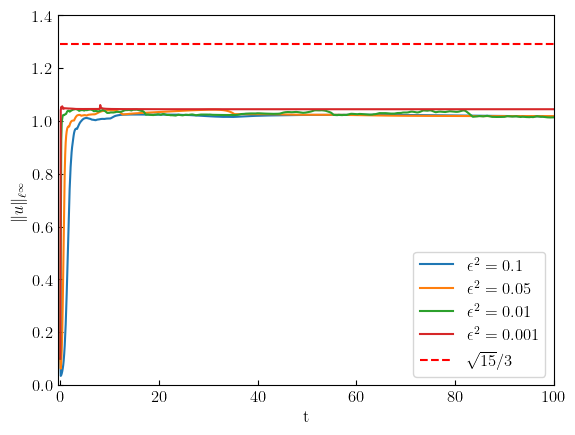

In [23]:
plt.plot(solver_eps1.tn[::10], maxValue_eps1  ,label = r"$\epsilon^2 = 0.1$" )
plt.plot(solver_eps1.tn[::10], maxValue_eps05 ,label = r"$\epsilon^2 = 0.05$" )
plt.plot(solver_eps1.tn[::10], maxValue_eps01 ,label = r"$\epsilon^2 = 0.01$" )
plt.plot(solver_eps1.tn[::10], maxValue_eps001,label = r"$\epsilon^2 = 0.001$" )
plt.hlines(np.sqrt(15)/3,0,solver_eps1.tn[-1],colors='r',linestyles='dashed',label='$\sqrt{15}/3$')
plt.ylim(0,1.4)
plt.xlim(-0.5,100)

plt.xlabel("t")
plt.ylabel(r"$\Vert u\Vert_{\ell^\infty}$")

plt.legend(loc= 'lower right')
plt.savefig("fig/ch_maximum.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

# Convergence tests

## Temporal convergence test

### $\epsilon^2 = 0.01 $

In [3]:
s_domain = (-1, 1)
discrete_num = [512]
xn = np.linspace(s_domain[0],s_domain[1],discrete_num[0]+1)
initial_condition = 0.1*(np.sin(3*np.pi*xn) + np.sin(5*np.pi*xn))

gf_type = "Hm1"
kappa = 2
delta = 1e-2
t_period = [0,0.1]

def err_test(eps_sq,start,end,step_method,ref_solution):
    err = []
    for i in range(start,end+1):
        solver = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,step_method)
        solver.solve(t_period,2**-i*delta)
        err.append(np.sqrt(np.mean(np.square(solver.Un[-1] - ref_solution[-1]))))
    return err

In [14]:
eps_sq = 0.01

tau_ref = delta*2**-12
solver_ref = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"ETDRK3")
solver_ref.solve(t_period,tau_ref)

start,end = 6,11

step_method = "EFRK1"
print(step_method)
err_efrk1_01 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "EFRK2"
print(step_method)
err_efrk2_01 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "EFRK3_Heun"
print(step_method)
err_efrk3_01 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

 0.10\0.1, Elapse: 0.002 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
EFRK1
 0.10\0.1, Elapse: 0.000 s, Energy:0.4977, Mass:0.0000, Maximum:0.22           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4977, Mass:0.0000, Maximum:0.22           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4977, Mass:-0.0000, Maximum:0.22          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.22           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
EFRK2
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, 

In [28]:
order_efrk1_01 = []
order_efrk2_01 = []
order_efrk3_01 = []

for i in range(1, end-start + 1):
        order_efrk1_01.append(np.log2(err_efrk1_01[i-1]/err_efrk1_01[i]))
        order_efrk2_01.append(np.log2(err_efrk2_01[i-1]/err_efrk2_01[i]))
        order_efrk3_01.append(np.log2(err_efrk3_01[i-1]/err_efrk3_01[i]))

In [55]:
table = [r"\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}",
r"\hline",
r"$\tau$          & Scheme                     & $\ell^2$ Error & Order         & Scheme                     & $\ell^2$ Error & Order & Scheme                     & $\ell^2$ Error & Order \\ \hline",
rf"$\delta/2^6$    & \multirow{{6}}{{*}}{{EFRK(1,1)}} & {err_efrk1_01[0]:.4e}  &  -            & \multirow{{6}}{{*}}{{EFRK(2,2)}} & {err_efrk2_01[0]:.4e} &  -     & \multirow{{6}}{{*}}{{EFRK(3,3)}} & {err_efrk3_01[0]:.4e} &  -      \\",
rf"$\delta/2^7$    &                            & {err_efrk1_01[1]:.4e}  &  {order_efrk1_01[0]:.2f}         &                            & {err_efrk2_01[1]:.4e}  &  {order_efrk2_01[0]:.2f}  &                            & {err_efrk3_01[1]:.4e}  &  {order_efrk3_01[0]:.2f}   \\",
rf"$\delta/2^8$    &                            & {err_efrk1_01[2]:.4e}  &  {order_efrk1_01[1]:.2f}         &                            & {err_efrk2_01[2]:.4e}  &  {order_efrk2_01[1]:.2f}  &                            & {err_efrk3_01[2]:.4e}  &  {order_efrk3_01[1]:.2f}   \\",
rf"$\delta/2^9$    &                            & {err_efrk1_01[3]:.4e}  &  {order_efrk1_01[2]:.2f}         &                            & {err_efrk2_01[3]:.4e}  &  {order_efrk2_01[2]:.2f}  &                            & {err_efrk3_01[3]:.4e}  &  {order_efrk3_01[2]:.2f}   \\",
rf"$\delta/2^{10}$   &                            & {err_efrk1_01[4]:.4e}  &  {order_efrk1_01[3]:.2f}         &                            & {err_efrk2_01[4]:.4e}  &  {order_efrk2_01[3]:.2f}  &                            & {err_efrk3_01[4]:.4e}  &  {order_efrk3_01[3]:.2f}   \\",
rf"$\delta/2^{11}$   &                            & {err_efrk1_01[5]:.4e}  &  {order_efrk1_01[4]:.2f}         &                            & {err_efrk2_01[5]:.4e}  &  {order_efrk2_01[4]:.2f}  &                            & {err_efrk3_01[5]:.4e}  &  {order_efrk3_01[4]:.2f}   \\ \hline",
r"\end{tabular}"]

print("\n".join(table))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
$\tau$          & Scheme                     & $\ell^2$ Error & Order         & Scheme                     & $\ell^2$ Error & Order & Scheme                     & $\ell^2$ Error & Order \\ \hline
$\delta/2^6$    & \multirow{6}{*}{EFRK(1,1)} & 4.0900e-03  &  -            & \multirow{6}{*}{EFRK(2,2)} & 8.5267e-05 &  -     & \multirow{6}{*}{EFRK(3,3)} & 1.2587e-06 &  -      \\
$\delta/2^7$    &                            & 2.0852e-03  &  0.97         &                            & 2.1814e-05  &  1.97  &                            & 1.6290e-07  &  2.95   \\
$\delta/2^8$    &                            & 1.0529e-03  &  0.99         &                            & 5.5181e-06  &  1.98  &                            & 2.0778e-08  &  2.97   \\
$\delta/2^9$    &                            & 5.2903e-04  &  0.99         &                            & 1.3878e-06  &  1.99  &                            & 2.6260e-09  &  2.98   \\
$\delta/2^10$   &           

### $\epsilon^2 = 0.0025$

In [52]:
eps_sq = 0.0025

tau_ref = delta*2**-12
solver_ref = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"ETDRK3")
solver_ref.solve(t_period,tau_ref)

start,end = 6,11

step_method = "EFRK1"
print(step_method)
err_efrk1_02 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "EFRK2"
print(step_method)
err_efrk2_02 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

step_method = "EFRK3_Heun"
print(step_method)
err_efrk3_02 = err_test(eps_sq,start,end,step_method,solver_ref.Un)

 0.10\0.1, Elapse: 0.002 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
EFRK1
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
EFRK2
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, 

In [53]:
order_efrk1_02 = []
order_efrk2_02 = []
order_efrk3_02 = []

for i in range(1, end-start + 1):
        order_efrk1_02.append(np.log2(err_efrk1_02[i-1]/err_efrk1_02[i]))
        order_efrk2_02.append(np.log2(err_efrk2_02[i-1]/err_efrk2_02[i]))
        order_efrk3_02.append(np.log2(err_efrk3_02[i-1]/err_efrk3_02[i]))

In [56]:
table = [r"\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}",
r"\hline",
r"$\tau$          & Scheme                     & $\ell^2$ Error & Order         & Scheme                     & $\ell^2$ Error & Order & Scheme                     & $\ell^2$ Error & Order \\ \hline",
rf"$\delta/2^6$    & \multirow{{6}}{{*}}{{EFRK(1,1)}} & {err_efrk1_02[0]:.4e}  &  -            & \multirow{{6}}{{*}}{{EFRK(2,2)}} & {err_efrk2_02[0]:.4e} &  -     & \multirow{{6}}{{*}}{{EFRK(3,3)}} & {err_efrk3_02[0]:.4e} &  -      \\",
rf"$\delta/2^7$    &                            & {err_efrk1_02[1]:.4e}  &  {order_efrk1_02[0]:.2f}         &                            & {err_efrk2_02[1]:.4e}  &  {order_efrk2_02[0]:.2f}  &                            & {err_efrk3_02[1]:.4e}  &  {order_efrk3_02[0]:.2f}   \\",
rf"$\delta/2^8$    &                            & {err_efrk1_02[2]:.4e}  &  {order_efrk1_02[1]:.2f}         &                            & {err_efrk2_02[2]:.4e}  &  {order_efrk2_02[1]:.2f}  &                            & {err_efrk3_02[2]:.4e}  &  {order_efrk3_02[1]:.2f}   \\",
rf"$\delta/2^9$    &                            & {err_efrk1_02[3]:.4e}  &  {order_efrk1_02[2]:.2f}         &                            & {err_efrk2_02[3]:.4e}  &  {order_efrk2_02[2]:.2f}  &                            & {err_efrk3_02[3]:.4e}  &  {order_efrk3_02[2]:.2f}   \\",
rf"$\delta/2^{10}$   &                            & {err_efrk1_02[4]:.4e}  &  {order_efrk1_02[3]:.2f}         &                            & {err_efrk2_02[4]:.4e}  &  {order_efrk2_02[3]:.2f}  &                            & {err_efrk3_02[4]:.4e}  &  {order_efrk3_02[3]:.2f}   \\",
rf"$\delta/2^{11}$   &                            & {err_efrk1_02[5]:.4e}  &  {order_efrk1_02[4]:.2f}         &                            & {err_efrk2_02[5]:.4e}  &  {order_efrk2_02[4]:.2f}  &                            & {err_efrk3_02[5]:.4e}  &  {order_efrk3_02[4]:.2f}   \\ \hline",
r"\end{tabular}"]

print("\n".join(table))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
$\tau$          & Scheme                     & $\ell^2$ Error & Order         & Scheme                     & $\ell^2$ Error & Order & Scheme                     & $\ell^2$ Error & Order \\ \hline
$\delta/2^6$    & \multirow{6}{*}{EFRK(1,1)} & 3.9485e-04  &  -            & \multirow{6}{*}{EFRK(2,2)} & 7.8463e-06 &  -     & \multirow{6}{*}{EFRK(3,3)} & 4.2049e-06 &  -      \\
$\delta/2^7$    &                            & 2.0906e-04  &  0.92         &                            & 3.4195e-06  &  1.20  &                            & 8.5690e-07  &  2.29   \\
$\delta/2^8$    &                            & 1.0804e-04  &  0.95         &                            & 1.1666e-06  &  1.55  &                            & 1.4953e-07  &  2.52   \\
$\delta/2^9$    &                            & 5.4982e-05  &  0.97         &                            & 3.4902e-07  &  1.74  &                            & 2.3264e-08  &  2.68   \\
$\delta/2^10$   &           

## Spatial convergence test

In [3]:
t_period = 0.1
s_domain = (-1,1)
discrete_num = [2048]
xn = np.linspace(s_domain[0],s_domain[1],discrete_num[0]+1)
initial_condition = 0.1*(np.sin(3*np.pi*xn) + np.sin(5*np.pi*xn))

gf_type = "Hm1"
kappa = 2
delta = 1e-2
t_period = [0,0.1]

In [4]:
eps_sq = 0.01

tau_ref = delta*2**-12
solver_ref = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"ETDRK3")
solver_ref.solve(t_period,tau_ref)

spatial_error = []
for i in range(2,11):
    xn = np.linspace(s_domain[0],s_domain[1],2**i+1)
    initial_condition = 0.1*(np.sin(3*np.pi*xn) + np.sin(5*np.pi*xn))
    globals()[f"efrk_spatial_{i}"] = gl_solver(gf_type,eps_sq,kappa,s_domain,[2**i],initial_condition,"EFRK3_Heun")
    globals()[f"efrk_spatial_{i}"].solve(t_period,tau_ref)
    spatial_error.append(np.sqrt(globals()[f"efrk_spatial_{i}"].h*np.sum(np.square(np.abs(globals()[f"efrk_spatial_{i}"].Un[-1]-solver_ref.Un[-1][::int(2048/2**i)])))))

 0.10\0.1, Elapse: 0.005 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
 0.10\0.1, Elapse: 0.000 s, Energy:0.5000, Mass:-0.0000, Maximum:0.00          
 0.10\0.1, Elapse: 0.000 s, Energy:0.5000, Mass:-0.0000, Maximum:0.00          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:-0.0000, Maximum:0.23          
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           
 0.10\0.1, Elapse: 0.000 s, Energy:0.4976, Mass:0.0000, Maximum:0.23           


In [5]:
discrete_num = [2048]
xn = np.linspace(s_domain[0],s_domain[1],discrete_num[0]+1)
initial_condition = 0.1*(np.sin(3*np.pi*xn) + np.sin(5*np.pi*xn))

eps_sq = 0.0025

tau_ref = delta*2**-12
solver_ref_02 = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"ETDRK3")
solver_ref_02.solve(t_period,tau_ref)

spatial_error_02 = []
for i in range(2,11):
    xn = np.linspace(s_domain[0],s_domain[1],2**i+1)
    initial_condition = 0.1*(np.sin(3*np.pi*xn) + np.sin(5*np.pi*xn))
    globals()[f"efrk_spatial_02_{i}"] = gl_solver(gf_type,eps_sq,kappa,s_domain,[2**i],initial_condition,"EFRK3_Heun")
    globals()[f"efrk_spatial_02_{i}"].solve(t_period,tau_ref)
    spatial_error_02.append(np.sqrt(globals()[f"efrk_spatial_02_{i}"].h*np.sum(np.square(np.abs(globals()[f"efrk_spatial_02_{i}"].Un[-1]-solver_ref_02.Un[-1][::int(2048/2**i)])))))

 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.5000, Mass:-0.0000, Maximum:0.00          
 0.10\0.1, Elapse: 0.000 s, Energy:0.5000, Mass:-0.0000, Maximum:0.00          
 0.10\0.1, Elapse: 0.000 s, Energy:0.2698, Mass:-0.0000, Maximum:0.95          
 0.10\0.1, Elapse: 0.000 s, Energy:0.2827, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:-0.0000, Maximum:0.97          
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:-0.0000, Maximum:0.97          
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           
 0.10\0.1, Elapse: 0.000 s, Energy:0.2826, Mass:0.0000, Maximum:0.97           


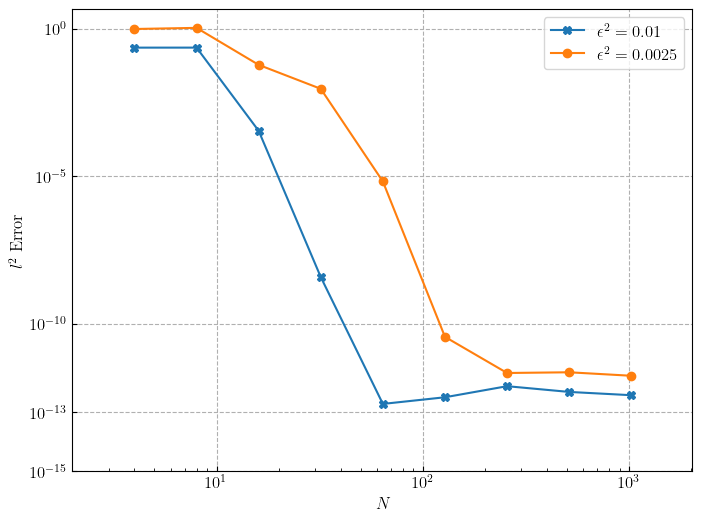

In [6]:
fig = plt.figure(figsize=(8,6))

plt.plot([2**i for i in range(2,11)],spatial_error,marker = "X",label = "$\epsilon^2=0.01$")

plt.plot([2**i for i in range(2,11)],spatial_error_02,marker = "o",label = "$\epsilon^2=0.0025$")

plt.xscale("log")
plt.xlabel("$N$")
plt.yscale("log")
plt.xlim(2,2024)
plt.ylim(10**-15,0)
plt.yticks([10**0,10**-5,10**-10,10**-13,10**-15])
plt.ylabel("$l^2$ Error")
plt.grid(linestyle="--")
plt.legend()

fig.savefig("fig/spatial_convg.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

# 2D Simulations

## High order advantage

In [3]:
t_period = [0,100]
s_domain = (-np.pi,-np.pi,np.pi,np.pi)
discrete_num = [128,128]
xn = np.linspace(s_domain[0],s_domain[1],discrete_num[1]+1)
yn = np.linspace(s_domain[0],s_domain[1],discrete_num[0]+1)
X,Y = np.meshgrid(xn,yn); X,Y = X[:-1,:-1],Y[:-1,:-1]
initial_condition = np.random.uniform(-0.5,0.5,(discrete_num[1]+1,discrete_num[0]+1))
gf_type = 'Hm1'

snapshot_time = [i for i in range(100+1)]
eps_sq = 0.05**2
kappa = 2

In [ ]:
solver_ref = gl_solver(gf_type,eps_sq,0,s_domain,discrete_num,initial_condition,"ETDRK3")
solver_ref.solve_long_time(t_period,1e-3,snapshot_time)

ch_efrk1 = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK1")
ch_efrk1.solve_long_time(t_period,1e-3,snapshot_time)

ch_efrk1_2 = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK1")
ch_efrk1_2.solve_long_time(t_period,1e-3/16,snapshot_time)

ch_efrk2 = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK2")
ch_efrk2.solve_long_time(t_period,1e-3,snapshot_time)

ch_efrk2_2 = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK2")
ch_efrk2_2.solve_long_time(t_period,1e-3/2,snapshot_time)

ch_efrk3 = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
ch_efrk3.solve_long_time(t_period,1e-3,snapshot_time)

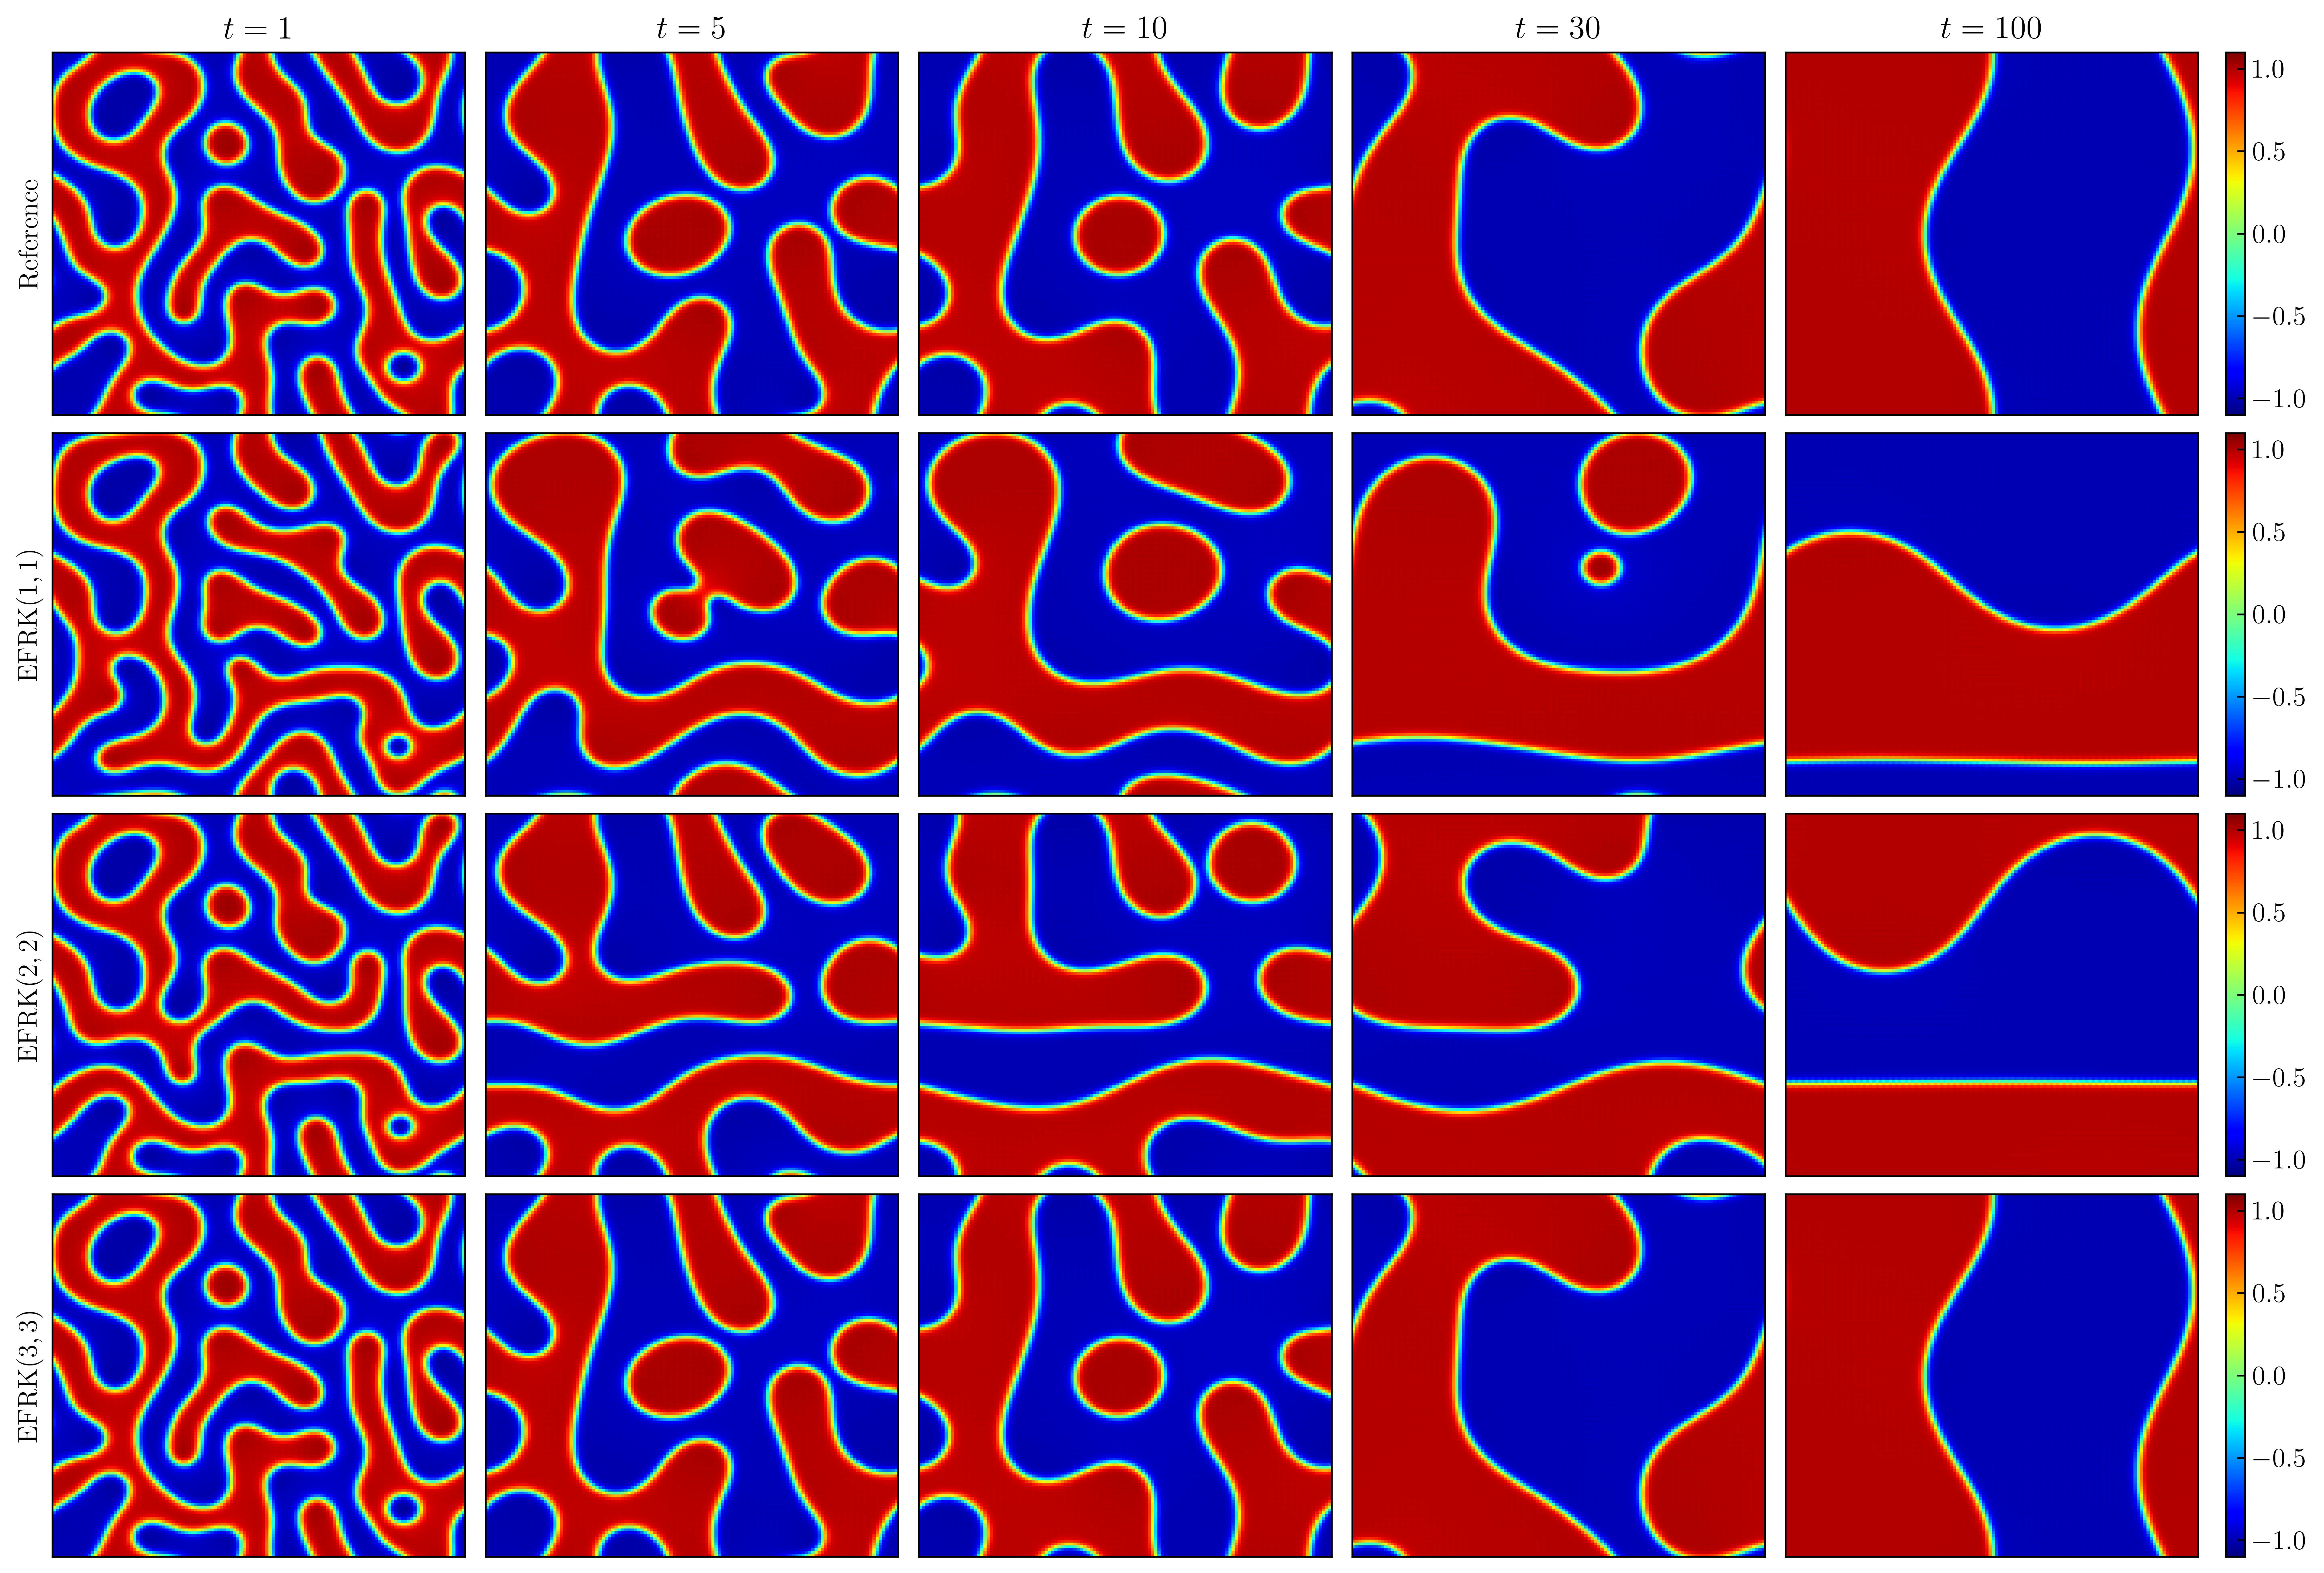

In [13]:
time_index = [1,5,10,30,100]
solvers = [solver_ref, ch_efrk1, ch_efrk2, ch_efrk3]

fig, axs = plt.subplots(figsize=(17, 12),dpi = 600, nrows=4 ,ncols= 5)
plt.subplots_adjust(wspace=0.05,hspace=0.05)
fig.patch.set_facecolor('white')
for i in range(len(solvers)):
    for j in range(len(time_index)):
        snapshot = axs[i,j].pcolormesh(solvers[i].Un[time_index[j]],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

        if j == 4:
            cax = add_right_cax(axs[i,j], pad = 0.01, width = 0.007)
            plt.colorbar(mappable= snapshot, cax = cax)
axs[0,0].set_ylabel("Reference")
axs[1,0].set_ylabel(r"EFRK$(1,1)$")
axs[2,0].set_ylabel(r"EFRK$(2,2)$")
axs[3,0].set_ylabel(r"EFRK$(3,3)$")

axs[0,0].set_title(rf"$t={time_index[0]}$")
axs[0,1].set_title(rf"$t={time_index[1]}$")
axs[0,2].set_title(rf"$t={time_index[2]}$")
axs[0,3].set_title(rf"$t={time_index[3]}$")
axs[0,4].set_title(rf"$t={time_index[4]}$")

plt.savefig("fig/2d_coarse_snapshot.pdf",dpi = 600, bbox_inches='tight',pad_inches=0.2)

plt.show()

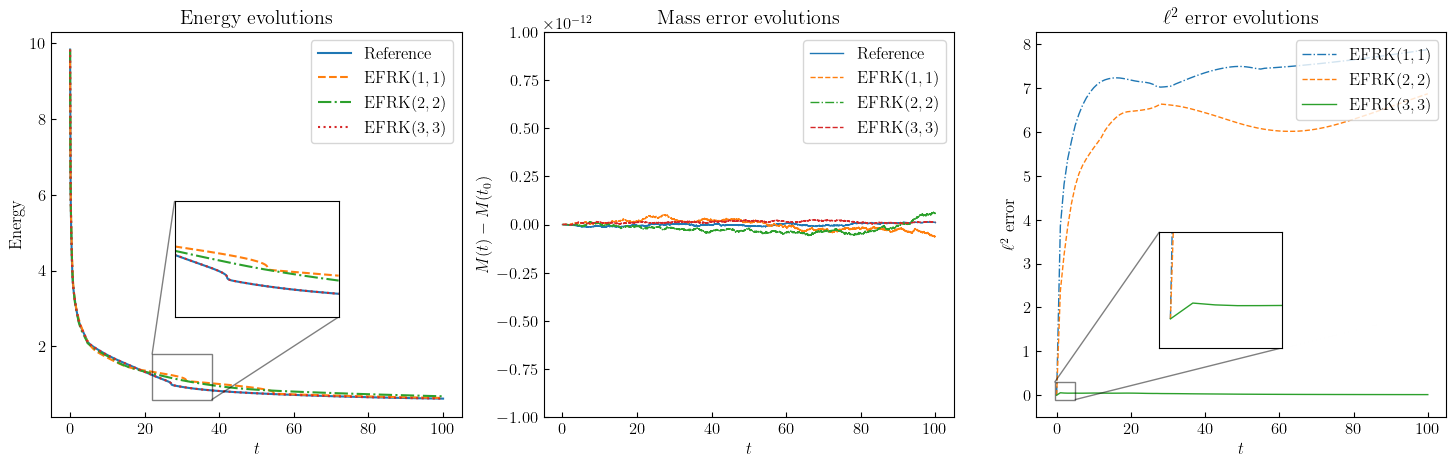

In [36]:
fig = plt.figure(figsize=(18,5))
ax = plt.subplot(1,3,1)
ax.plot(solver_ref.tn,solver_ref.En,"-" ,label = r"Reference")
ax.plot(ch_efrk1.tn,ch_efrk1.En,"--",label = r"EFRK$(1,1)$")
ax.plot(ch_efrk2.tn,ch_efrk2.En,"-.",label = r"EFRK$(2,2)$")
ax.plot(ch_efrk3.tn,ch_efrk3.En,":" ,label = r"EFRK$(3,3)$")
ax.set_title("Energy evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("Energy")
ax.legend(loc="upper right")

axins = ax.inset_axes([0.3,0.26,0.4,0.3])
axins.plot(solver_ref.tn,solver_ref.En,"-" )
axins.plot(ch_efrk1.tn,ch_efrk1.En,"--")
axins.plot(ch_efrk2.tn,ch_efrk2.En,"-.")
axins.plot(ch_efrk3.tn,ch_efrk3.En,":")
axins.set_xlim(22,38)
axins.set_ylim(0.6,1.8)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(1,3,2)
ax.plot(solver_ref.tn[::20],(solver_ref.Mn - solver_ref.Mn[0])[::20],"-" ,linewidth = 1,label = r"Reference")
ax.plot(ch_efrk1.tn[::20],(ch_efrk1.Mn - ch_efrk1.Mn[0])[::20],"--",linewidth = 1,label = r"EFRK$(1,1)$")
ax.plot(ch_efrk2.tn[::20],(ch_efrk2.Mn - ch_efrk2.Mn[0])[::20],"-.",linewidth = 1,label = r"EFRK$(2,2)$")
ax.plot(ch_efrk3.tn[::20],(ch_efrk3.Mn - ch_efrk3.Mn[0])[::20],"--",linewidth = 1,label = r"EFRK$(3,3)$")
ax.set_ylim(-1e-12,1e-12)
ax.set_title("Mass error evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("$M(t) - M(t_0)$")
ax.legend(loc="upper right")

ax = plt.subplot(1,3,3)


ax.plot(snapshot_time,np.sqrt(ch_efrk1.h*np.sum(np.square(solver_ref.Un - ch_efrk1.Un), axis=(1,2))),"-.",linewidth = 1,label = r"EFRK$(1,1)$")
ax.plot(snapshot_time,np.sqrt(ch_efrk2.h*np.sum(np.square(solver_ref.Un - ch_efrk2.Un),axis=(1,2))),"--",linewidth = 1,label = r"EFRK$(2,2)$")
ax.plot(snapshot_time,np.sqrt(ch_efrk3.h*np.sum(np.square(solver_ref.Un - ch_efrk3.Un),axis=(1,2))),"-",linewidth = 1,label = r"EFRK$(3,3)$")
ax.set_title("$\ell^2$ error evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("$\ell^2$ error")
ax.legend(loc="upper right")

axins = ax.inset_axes([0.3,0.18,0.3,0.3])
axins.plot(snapshot_time,np.sqrt(ch_efrk1.h*np.sum(np.square(solver_ref.Un - ch_efrk1.Un), axis=(1,2))),"-.",linewidth = 1,label = r"EFRK$(1,1)$")
axins.plot(snapshot_time,np.sqrt(ch_efrk2.h*np.sum(np.square(solver_ref.Un - ch_efrk2.Un),axis=(1,2))),"--",linewidth = 1,label = r"EFRK$(2,2)$")
axins.plot(snapshot_time,np.sqrt(ch_efrk3.h*np.sum(np.square(solver_ref.Un - ch_efrk3.Un),axis=(1,2))),"-",linewidth = 1,label = r"EFRK$(3,3)$")
axins.set_xlim(-0.5,5)
axins.set_ylim(-0.1,0.3)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.subplots_adjust(wspace=0.2,hspace=0.15)
fig.savefig("fig/advantage_prop.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

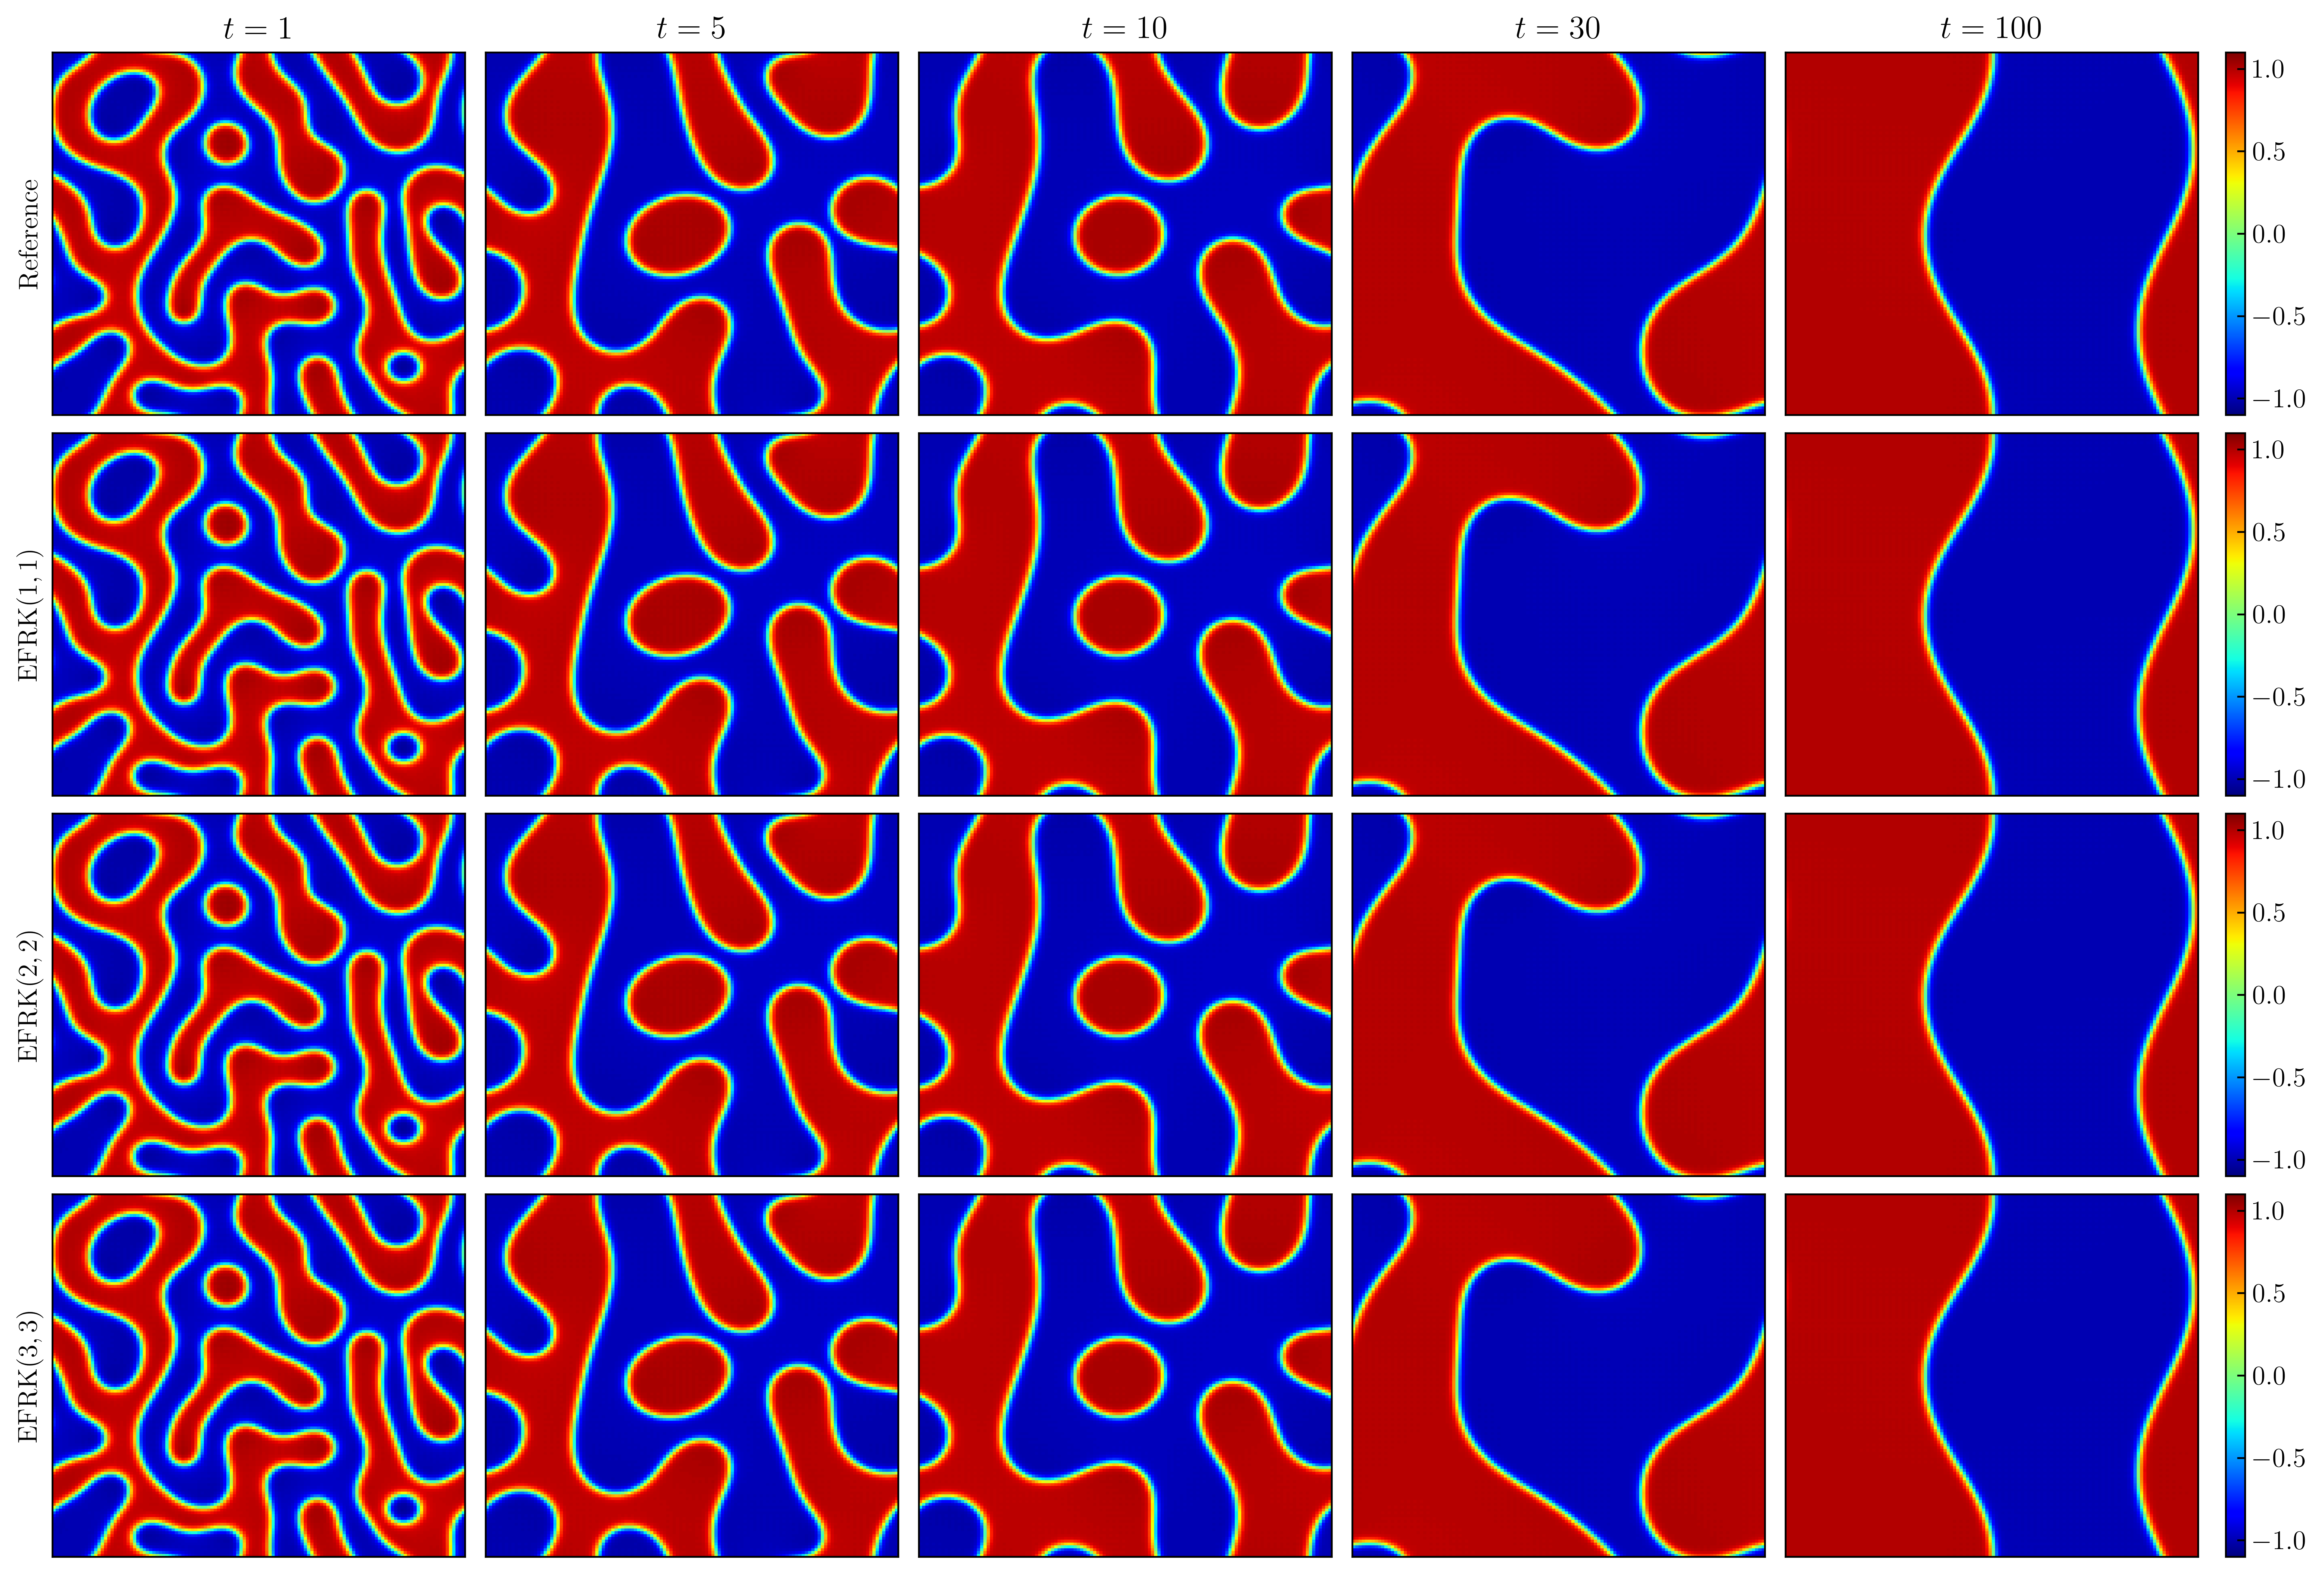

In [22]:
time_index = [1,5,10,30,100]
solvers = [solver_ref, ch_efrk1_2, ch_efrk2_2, ch_efrk3]

fig, axs = plt.subplots(figsize=(17, 12),dpi = 600, nrows=4 ,ncols= 5)
plt.subplots_adjust(wspace=0.05,hspace=0.05)
fig.patch.set_facecolor('white')
for i in range(len(solvers)):
    for j in range(len(time_index)):
        snapshot = axs[i,j].pcolormesh(solvers[i].Un[time_index[j]],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

        if j == 4:
            cax = add_right_cax(axs[i,j], pad = 0.01, width = 0.007)
            plt.colorbar(mappable= snapshot, cax = cax)

axs[0,0].set_ylabel("Reference")
axs[1,0].set_ylabel(r"EFRK$(1,1)$")
axs[2,0].set_ylabel(r"EFRK$(2,2)$")
axs[3,0].set_ylabel(r"EFRK$(3,3)$")

axs[0,0].set_title(rf"$t={time_index[0]}$")
axs[0,1].set_title(rf"$t={time_index[1]}$")
axs[0,2].set_title(rf"$t={time_index[2]}$")
axs[0,3].set_title(rf"$t={time_index[3]}$")
axs[0,4].set_title(rf"$t={time_index[4]}$")

plt.savefig("fig/2d_coarse_snapshot_2.pdf",dpi = 600, bbox_inches='tight',pad_inches=0.2)

plt.show()

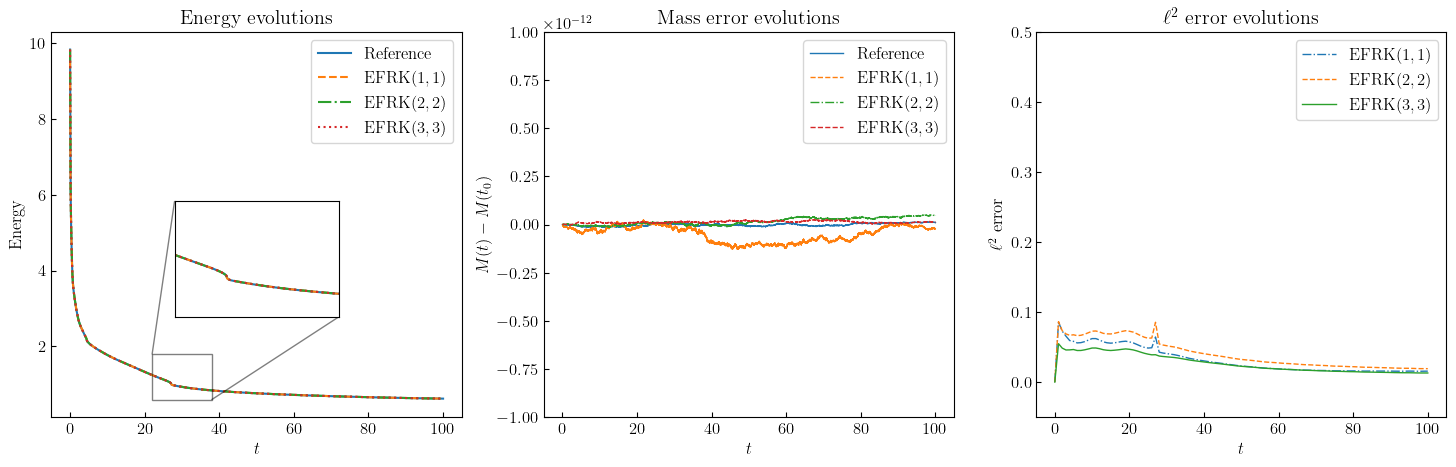

In [30]:
fig = plt.figure(figsize=(18,5))
ax = plt.subplot(1,3,1)
ax.plot(solver_ref.tn,solver_ref.En,"-" ,label = r"Reference")
ax.plot(ch_efrk1_2.tn,ch_efrk1_2.En,"--",label = r"EFRK$(1,1)$")
ax.plot(ch_efrk2_2.tn,ch_efrk2_2.En,"-.",label = r"EFRK$(2,2)$")
ax.plot(ch_efrk3.tn,ch_efrk3.En,":" ,label = r"EFRK$(3,3)$")
ax.set_title("Energy evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("Energy")
ax.legend(loc="upper right")

axins = ax.inset_axes([0.3,0.26,0.4,0.3])
axins.plot(solver_ref.tn,solver_ref.En,"-" )
axins.plot(ch_efrk1_2.tn,ch_efrk1_2.En,"--")
axins.plot(ch_efrk2_2.tn,ch_efrk2_2.En,"-.")
axins.plot(ch_efrk3.tn,ch_efrk3.En,":")
axins.set_xlim(22,38)
axins.set_ylim(0.6,1.8)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(1,3,2)
ax.plot(solver_ref.tn[::20],(solver_ref.Mn - solver_ref.Mn[0])[::20],"-" ,linewidth = 1,label = r"Reference")
ax.plot(ch_efrk1_2.tn[::20],(ch_efrk1_2.Mn - ch_efrk1_2.Mn[0])[::20],"--",linewidth = 1,label = r"EFRK$(1,1)$")
ax.plot(ch_efrk2_2.tn[::20],(ch_efrk2_2.Mn - ch_efrk2_2.Mn[0])[::20],"-.",linewidth = 1,label = r"EFRK$(2,2)$")
ax.plot(ch_efrk3.tn[::20],(ch_efrk3.Mn - ch_efrk3.Mn[0])[::20],"--",linewidth = 1,label = r"EFRK$(3,3)$")
ax.set_ylim(-1e-12,1e-12)
ax.set_title("Mass error evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("$M(t) - M(t_0)$")
ax.legend(loc="upper right")

ax = plt.subplot(1,3,3)


ax.plot(snapshot_time,np.sqrt(ch_efrk1_2.h*np.sum(np.square(solver_ref.Un - ch_efrk1_2.Un), axis=(1,2))),"-.",linewidth = 1,label = r"EFRK$(1,1)$")
ax.plot(snapshot_time,np.sqrt(ch_efrk2_2.h*np.sum(np.square(solver_ref.Un - ch_efrk2_2.Un),axis=(1,2))),"--",linewidth = 1,label = r"EFRK$(2,2)$")
ax.plot(snapshot_time,np.sqrt(ch_efrk3.h  *np.sum(np.square(solver_ref.Un - ch_efrk3.Un),axis=(1,2))),"-",linewidth = 1,label = r"EFRK$(3,3)$")
ax.set_ylim(-0.05,0.5)
ax.set_title("$\ell^2$ error evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("$\ell^2$ error")
ax.legend(loc="upper right")

plt.subplots_adjust(wspace=0.2,hspace=0.15)
fig.savefig("fig/advantage_prop_2.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

## Adaptive algorithm

In [8]:
t_period = [0,100]
s_domain = (-np.pi,-np.pi,np.pi,np.pi)
discrete_num = [128,128]
xn = np.linspace(s_domain[0],s_domain[1],discrete_num[1]+1)
yn = np.linspace(s_domain[0],s_domain[1],discrete_num[0]+1)
X,Y = np.meshgrid(xn,yn); X,Y = X[:-1,:-1],Y[:-1,:-1]
initial_condition = np.random.uniform(-0.5,0.5,(discrete_num[1]+1,discrete_num[0]+1))
gf_type = 'Hm1'

snapshot_time = [i for i in range(100+1)]
eps_sq = 0.05**2
kappa = 2

In [ ]:
ch_solver_tau_fine_step = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
ch_solver_tau_fine_step.solve_long_time([0,100],1e-5,snapshot_time)

ch_solver_adaptive = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
ch_solver_adaptive.solve_adaptive([0,100],1e-5,1e-2,100)

ch_solver_tau_coarse_step = gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
ch_solver_tau_coarse_step.solve_long_time([0,100],1e-2,snapshot_time)

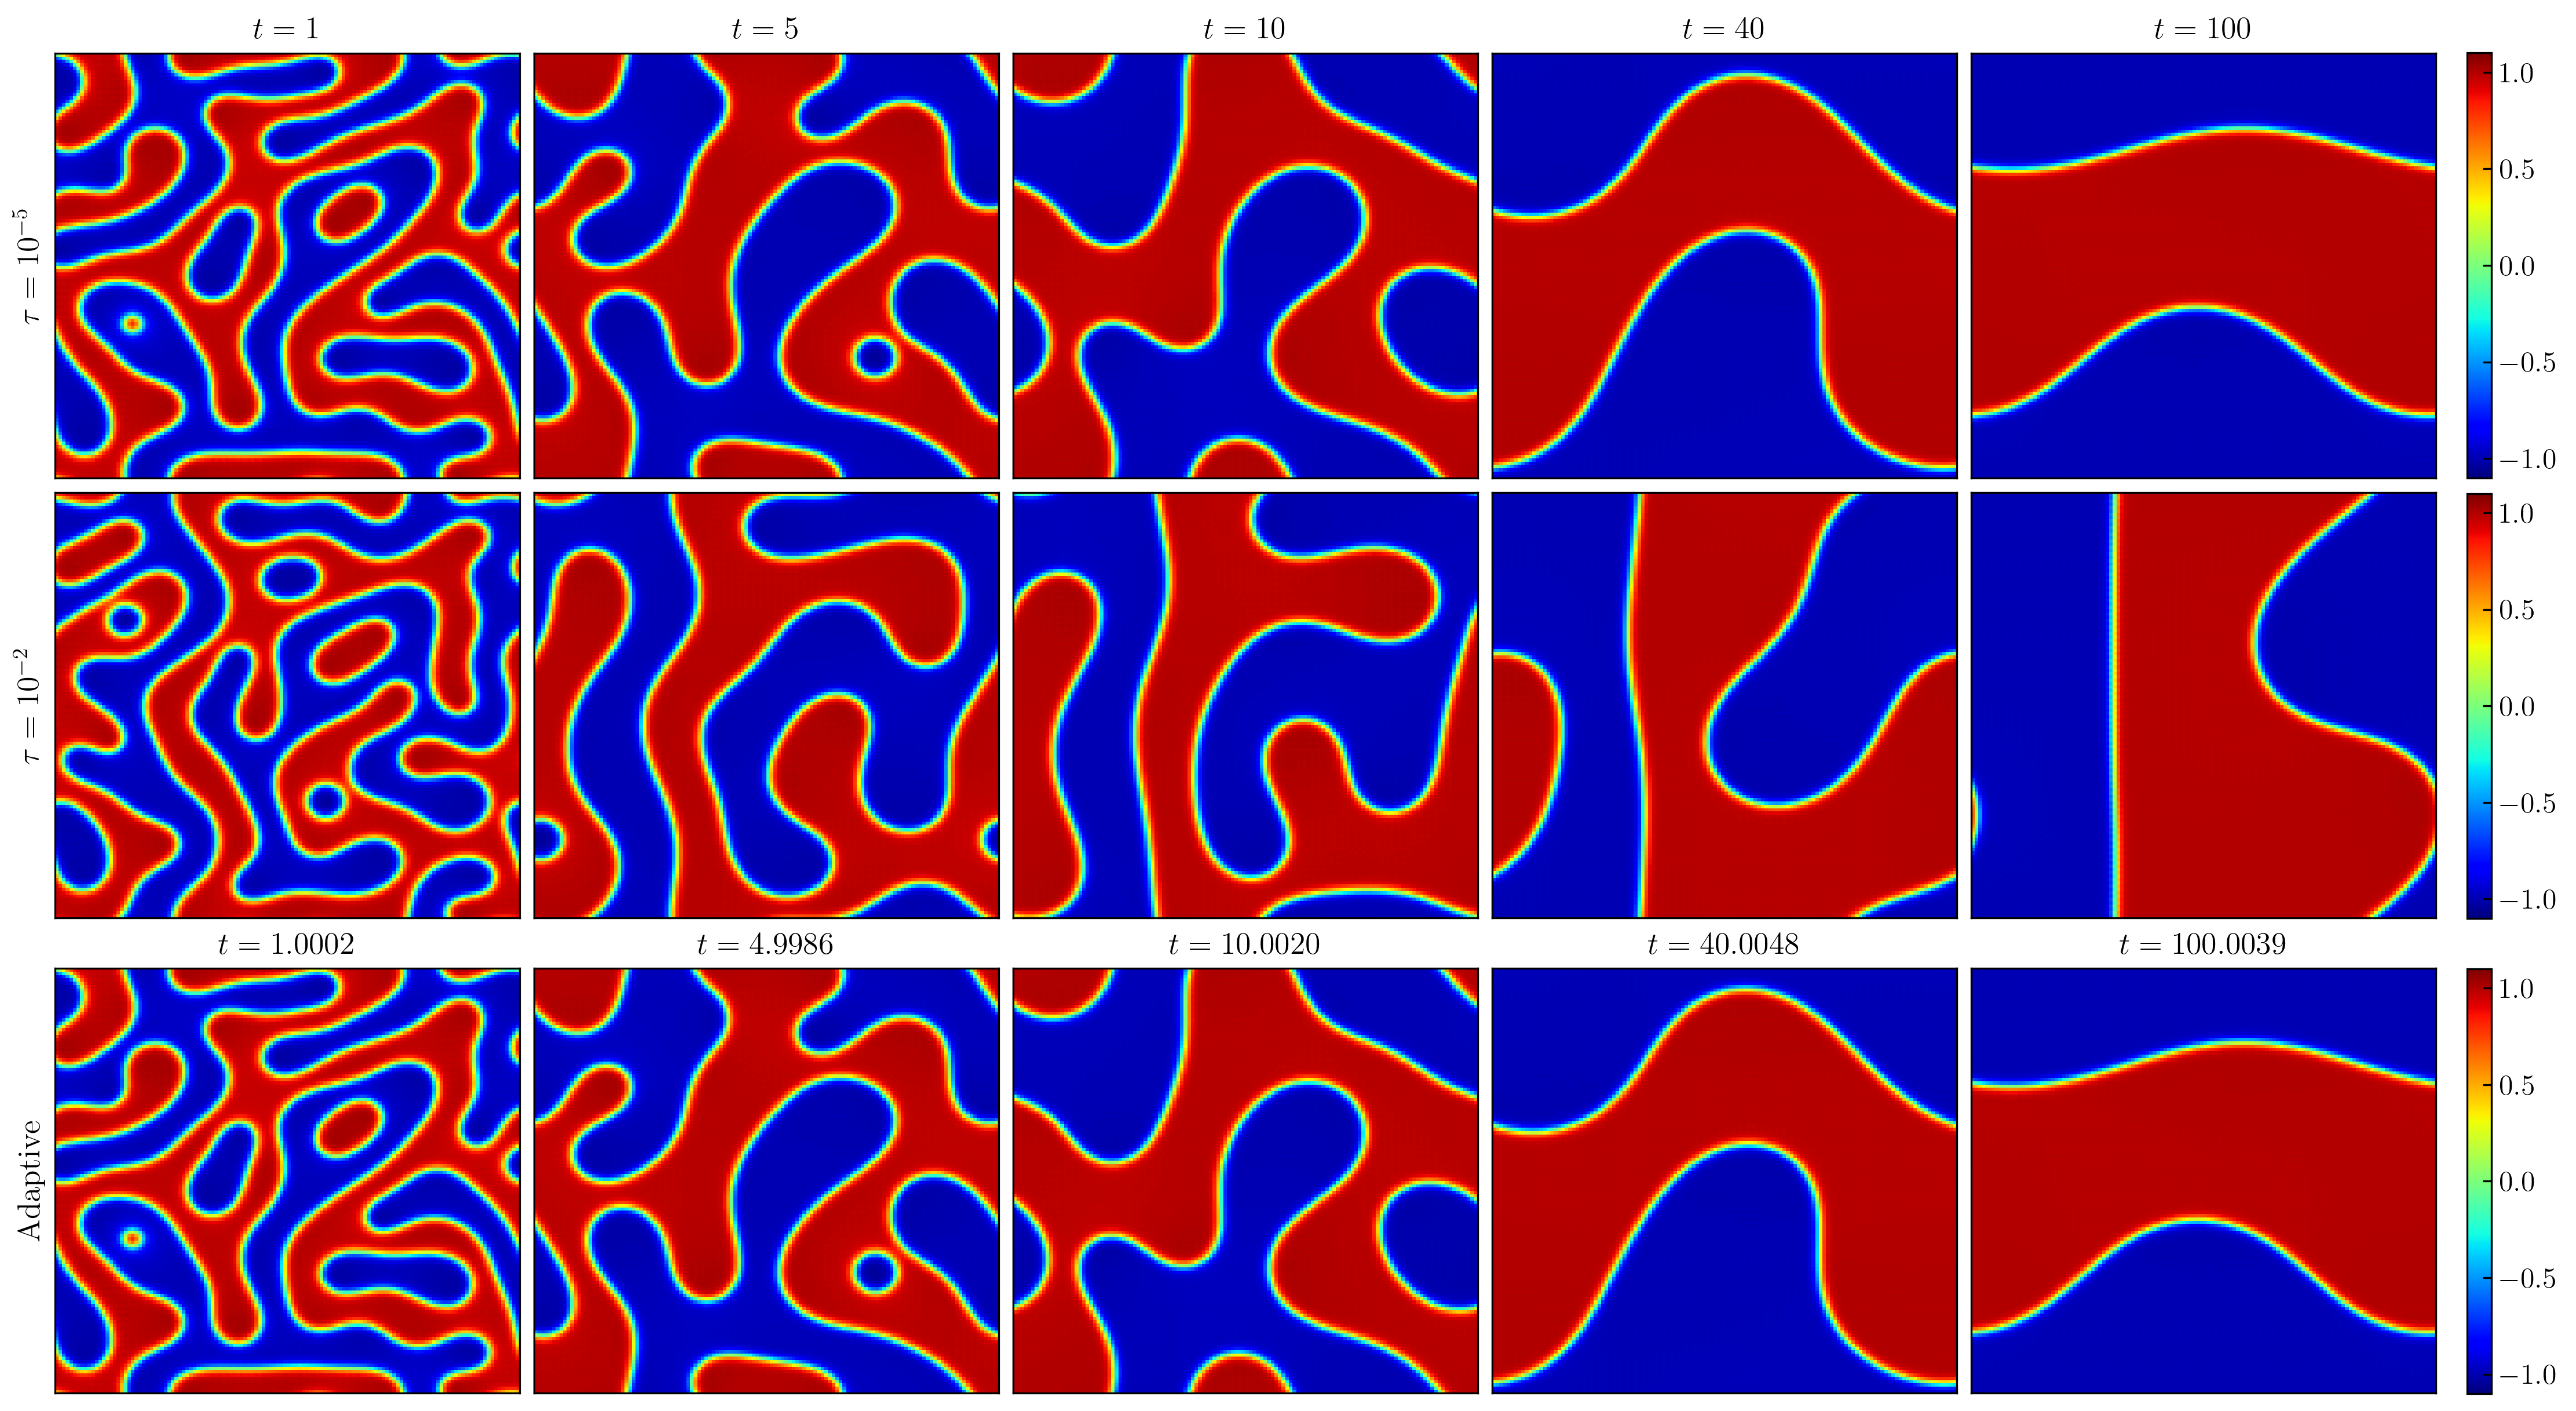

In [110]:

shot_time = [1,5,10,40,100]
adaptive_time_index = [find_nearest(ch_solver_adaptive.tn,t) for t in shot_time] 
adaptive_shot_time = [t for t in ch_solver_adaptive.tn[adaptive_time_index]]

fig = plt.figure(figsize=(14, 8),dpi = 300,constrained_layout=True)
gs = gridspec.GridSpec(3, 5, figure=fig, height_ratios=[1, 1, 1])
axs = []
for i in range(3):
    axs.append([fig.add_subplot(gs[i,0]),fig.add_subplot(gs[i,1]),fig.add_subplot(gs[i,2]),fig.add_subplot(gs[i,3]),fig.add_subplot(gs[i,4])])
axs = np.array(axs)

fig.patch.set_facecolor('white')
for i,t in enumerate(shot_time):
        snapshot = axs[0,i].pcolormesh(ch_solver_tau_fine_step.Un[t],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        snapshot = axs[1,i].pcolormesh(ch_solver_tau_coarse_step.Un[t],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])

        snapshot = axs[2,i].pcolormesh(ch_solver_adaptive.Un[adaptive_time_index[i]],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[2,i].set_xticks([])
        axs[2,i].set_yticks([])

cax = add_right_cax(axs[0,4], pad = 0.11, width = 0.01, pad_y=0.01, height=0.079 )
plt.colorbar(mappable= snapshot, cax = cax)
cax = add_right_cax(axs[1,4], pad = 0.11, width = 0.01, pad_y=-0.035, height=0.079 )
plt.colorbar(mappable= snapshot, cax = cax)
cax = add_right_cax(axs[2,4], pad = 0.11, width = 0.01, pad_y=-0.105, height=0.079 )
plt.colorbar(mappable= snapshot, cax = cax)


axs[0,0].set_ylabel(r"$\tau = 10^{-5}$",fontsize = 13)
axs[1,0].set_ylabel(r"$\tau = 10^{-2}$",fontsize = 13)
axs[2,0].set_ylabel(r"Adaptive"        ,fontsize = 13)

axs[0,0].set_title(rf"$t={shot_time[0]}$",fontsize = 13)
axs[0,1].set_title(rf"$t={shot_time[1]}$",fontsize = 13)
axs[0,2].set_title(rf"$t={shot_time[2]}$",fontsize = 13)
axs[0,3].set_title(rf"$t={shot_time[3]}$",fontsize = 13)
axs[0,4].set_title(rf"$t={shot_time[4]}$",fontsize = 13)


axs[2,0].set_title(rf"$t={adaptive_shot_time[0]:.4f}$",fontsize = 13)
axs[2,1].set_title(rf"$t={adaptive_shot_time[1]:.4f}$",fontsize = 13)
axs[2,2].set_title(rf"$t={adaptive_shot_time[2]:.4f}$",fontsize = 13)
axs[2,3].set_title(rf"$t={adaptive_shot_time[3]:.4f}$",fontsize = 13)
axs[2,4].set_title(rf"$t={adaptive_shot_time[4]:.4f}$",fontsize = 13)

fig.savefig("fig/adaptive_snapshot.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)
plt.show()

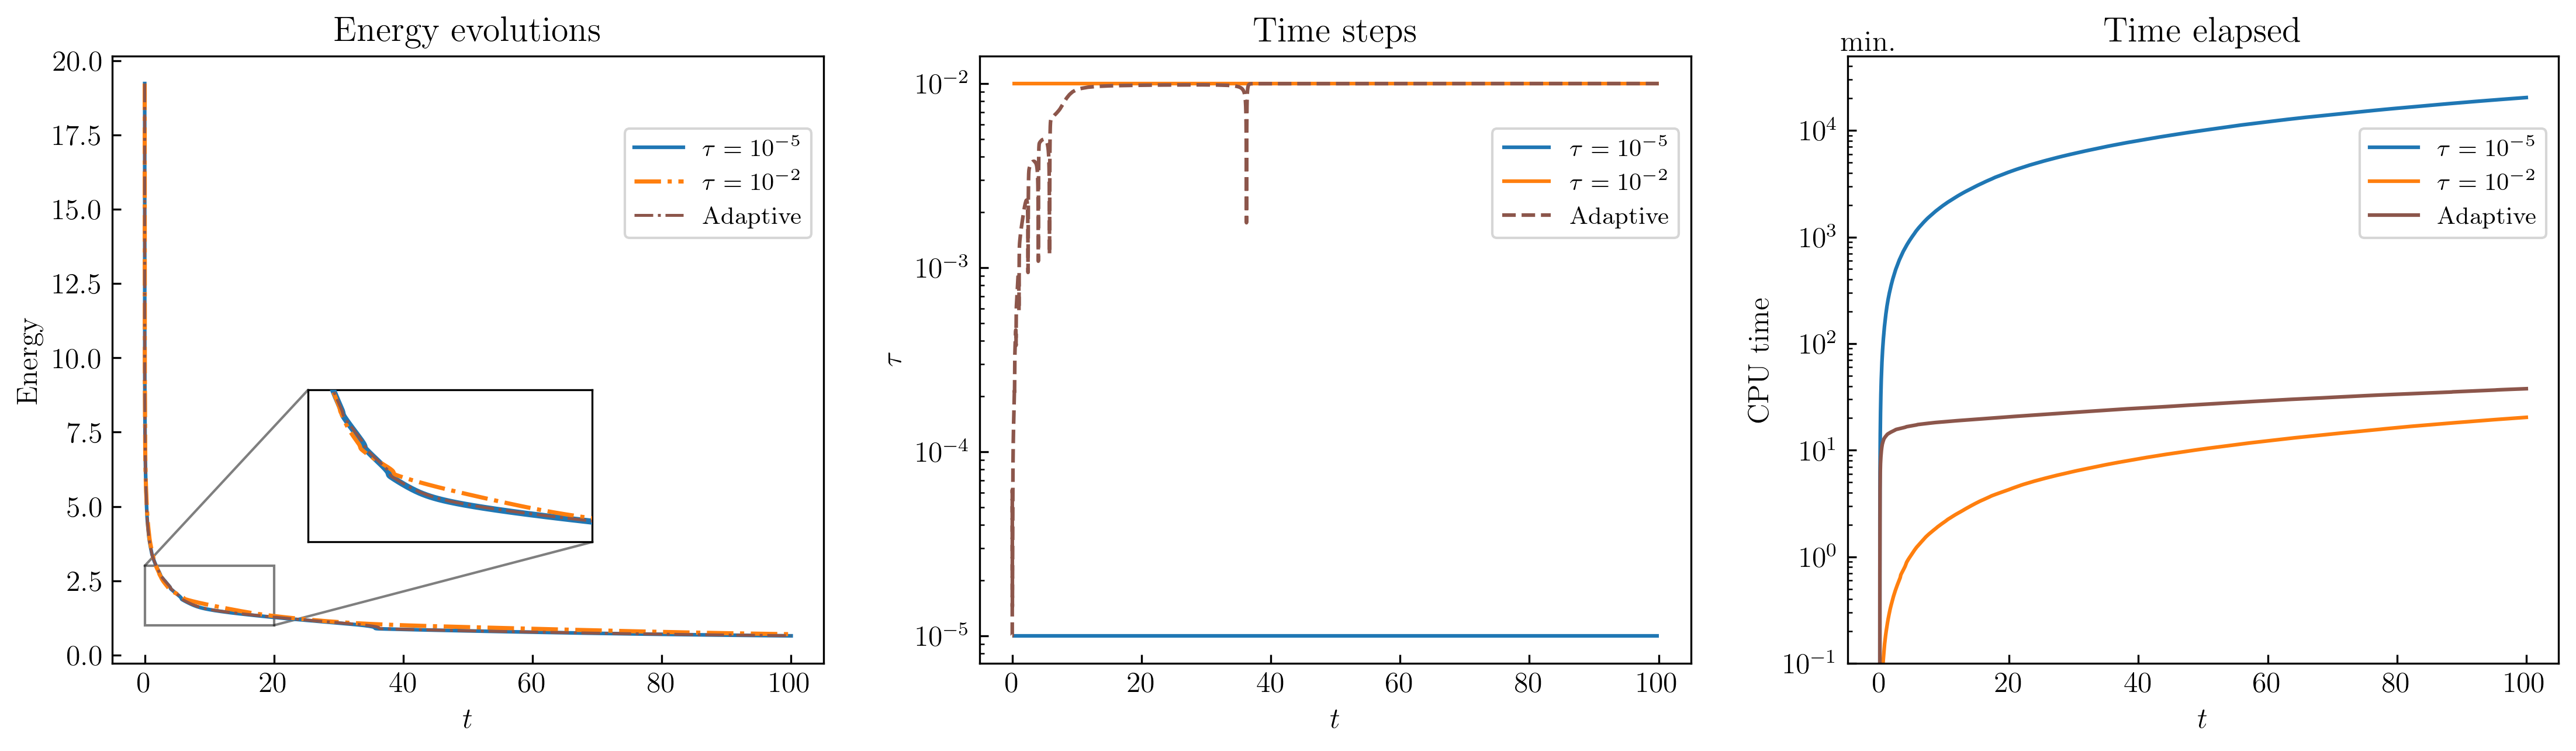

In [111]:
fig = plt.figure(figsize=(18,4.5),dpi=300)

ax = plt.subplot(1,3,1)
ax.plot(ch_solver_tau_fine_step.tn,ch_solver_tau_fine_step.En,"-",linewidth = 1.5,label=r"$\tau = 10^{-5}$",zorder = 101)
ax.plot(ch_solver_tau_coarse_step.tn,ch_solver_tau_coarse_step.En,"-.",linewidth = 1.7,color = "C1",label=r"$\tau = 10^{-2}$",zorder = 102)
ax.plot(ch_solver_adaptive.tn,ch_solver_adaptive.En,linestyle = "-.",color = "C5",linewidth = 1.2,label="Adaptive",zorder = 103)
ax.set_title("Energy evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("Energy")
ax.legend(loc = "upper right",fontsize = "small",bbox_to_anchor=(1.,0.9))

axins = ax.inset_axes([0.275,0.2,0.4,0.25])
axins.plot(ch_solver_tau_fine_step.tn,ch_solver_tau_fine_step.En,"-",color = "C0",linewidth = 2.5,label=r"$\tau = 10^{-5}$",zorder = 101)
axins.plot(ch_solver_tau_coarse_step.tn,ch_solver_tau_coarse_step.En,"-.",linewidth = 1.7,color = "C1",label=r"$\tau = 10^{-2}$",zorder = 102)
axins.plot(ch_solver_adaptive.tn,ch_solver_adaptive.En,linestyle = "-.",color = "C5",linewidth = 1.2,label="Adaptive",zorder = 103)
axins.set_xticks([])    
axins.set_yticks([])
axins.set_xlim(0,20)
axins.set_ylim(1,3)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(1,3,2)
ax.hlines(1e-5,0,100,color = "C0",label=r"$\tau = 10^{-5}$",zorder = 201)
ax.hlines(1e-2,0,100,color = "C1",ls = "-",label=r"$\tau = 10^{-2}$",zorder = 202)
ax.plot(ch_solver_adaptive.tn,ch_solver_adaptive.tau_list,"--",color = "C5",label="Adaptive",zorder = 203)
ax.set_title("Time steps")
ax.set_xlabel("$t$")
ax.set_ylabel(r"$\tau$")
ax.set_yscale("log")
ax.legend(loc = "upper right",fontsize = "small",bbox_to_anchor=(1.,0.9))

ax = plt.subplot(1,3,3)
ax.plot(ch_solver_tau_fine_step.tn,ch_solver_tau_fine_step.time_elapse * 10,label=r"$\tau = 10^{-5}$")
ax.plot(ch_solver_tau_coarse_step.tn,ch_solver_tau_coarse_step.time_elapse,color = "C1",label=r"$\tau = 10^{-2}$")
ax.plot(ch_solver_adaptive.tn,ch_solver_adaptive.time_elapse,color="C5",label="Adaptive")
ax.set_title("Time elapsed")
ax.set_xlabel("$t$")
ax.set_ylabel("CPU time")
ax.set_yscale("log")
ax.set_ylim(0.1,50000)
ax.text(-0.01,1.0,"min.",horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
ax.legend(loc = "upper right",fontsize = "small",bbox_to_anchor=(1.,0.9))

plt.subplots_adjust(wspace=0.22)
fig.savefig("fig/adaptive_property.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)

## Equilibrium preserving v.s non-equilibrium preserving

In [3]:
t_period = [0,50]
s_domain = (0, 0, 2*np.pi, 2*np.pi)
discrete_num = [128,128]
xn = np.linspace(s_domain[0],s_domain[1],discrete_num[1]+1)
yn = np.linspace(s_domain[0],s_domain[1],discrete_num[0]+1)
X,Y = np.meshgrid(xn,yn); X,Y = X[:-1,:-1],Y[:-1,:-1]
initial_condition = np.random.uniform(-0.5,0.5,(discrete_num[1]+1,discrete_num[0]+1))

gf_type = 'Hm1'
eps_sq = 0.002
kappa = 2

snapshot_time = [i for i in range(50+1)]

In [4]:
CH_solver_ETDRK3_ref =  gl_solver(gf_type,eps_sq,0,s_domain,discrete_num,initial_condition,"ETDRK3")
CH_solver_ETDRK3_ref.solve_long_time(t_period,1e-5,snapshot_time)

 50.00\50, Elapse: 0.002 s, Energy:0.8717, Mass:0.0076, Maximum:1.01     


In [5]:
CH_solver_EFRK2_adaptive =  gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK2")
CH_solver_EFRK2_adaptive.solve_adaptive(t_period,1e-5,1e-2,100)

CH_solver_EFRK3_adaptive =  gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"EFRK3_Heun")
CH_solver_EFRK3_adaptive.solve_adaptive(t_period,1e-5,1e-2,100)


 50.00\50, Step size: 9.98e-03, Elapse: 0.001 s, Energy:0.8921, Mass:0.0076, Maximum:1.01          
 49.99\50, Step size: 9.98e-03, Elapse: 0.002 s, Energy:0.8819, Mass:0.0076, Maximum:1.01          


In [6]:

CH_solver_IFRK3_adaptive =  gl_solver(gf_type,eps_sq,kappa,s_domain,discrete_num,initial_condition,"IFRK3_Heun")
CH_solver_IFRK3_adaptive.solve_adaptive(t_period,1e-5,1e-2,100)

 50.00\50, Step size: 8.51e-04, Elapse: 0.003 s, Energy:0.8467, Mass:0.0076, Maximum:1.01          


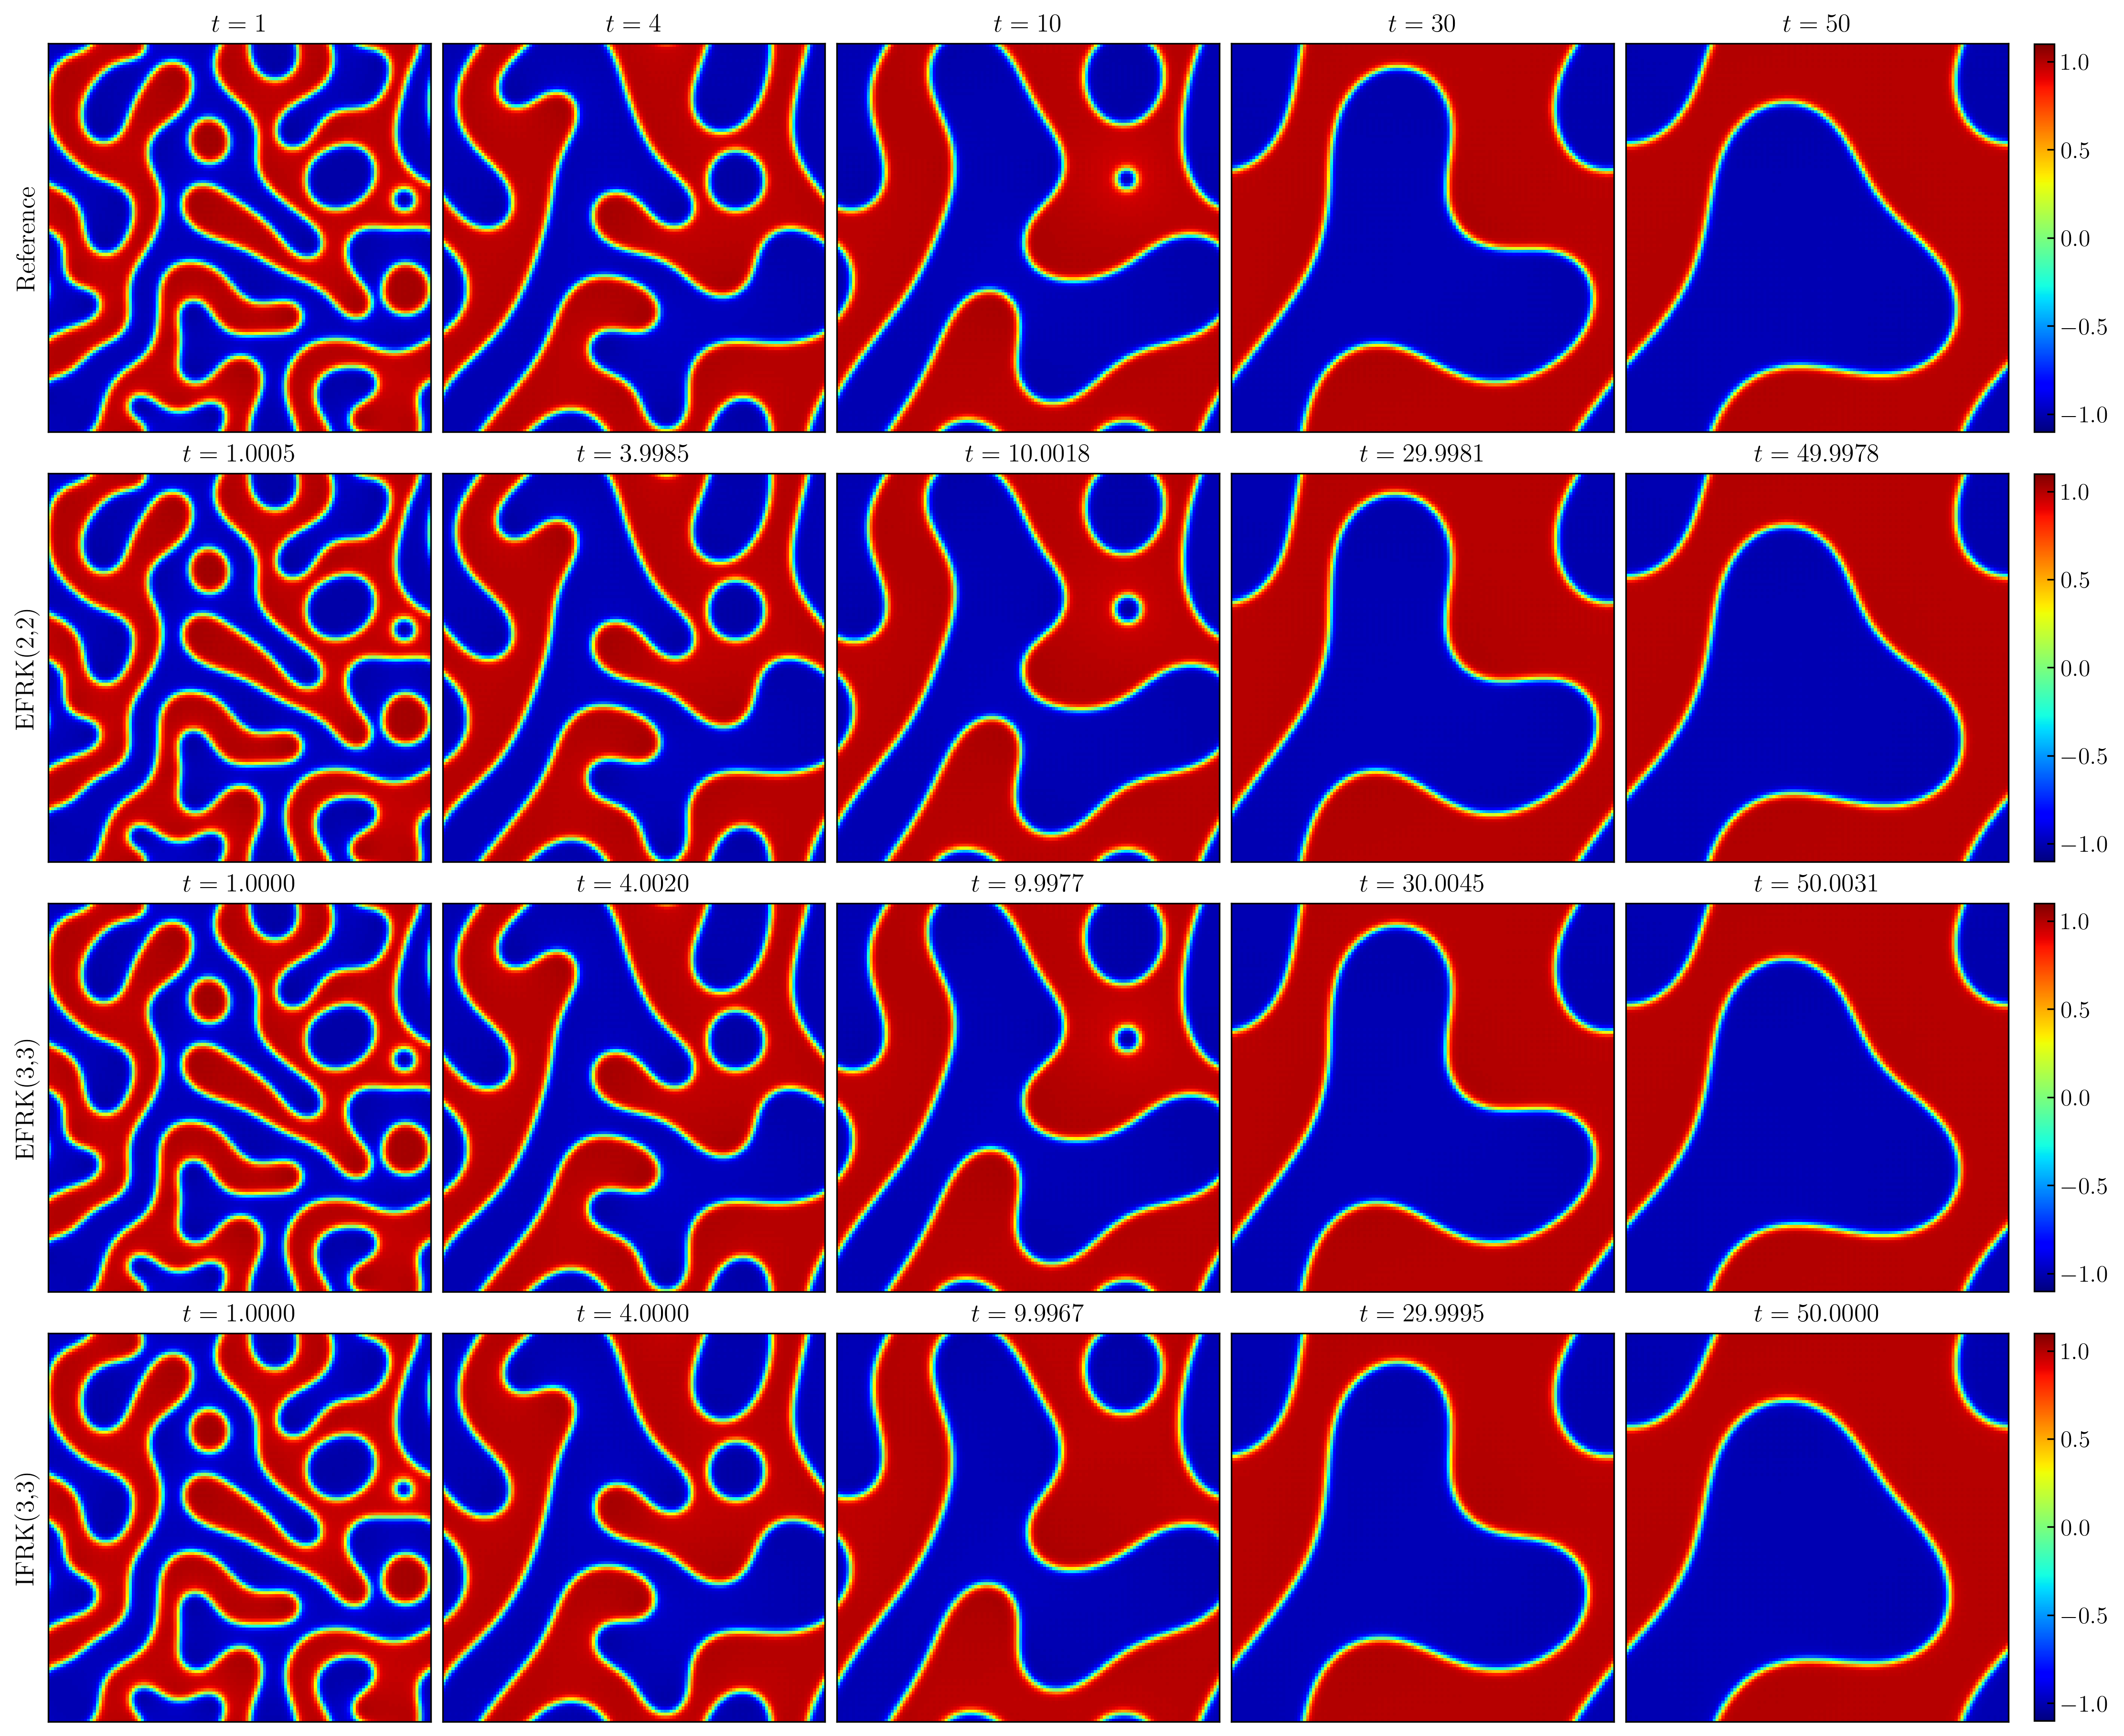

In [7]:
shot_time = [1,4,10,30,50]

adaptive_EFRK2_time_index = [find_nearest(CH_solver_EFRK2_adaptive.tn,t) for t in shot_time] 
adaptive_EFRK2_shot_time = [t for t in CH_solver_EFRK2_adaptive.tn[adaptive_EFRK2_time_index]]

adaptive_EFRK3_time_index = [find_nearest(CH_solver_EFRK3_adaptive.tn,t) for t in shot_time] 
adaptive_EFRK3_shot_time = [t for t in CH_solver_EFRK3_adaptive.tn[adaptive_EFRK3_time_index]]

adaptive_IFRK3_time_index = [find_nearest(CH_solver_IFRK3_adaptive.tn,t) for t in shot_time] 
adaptive_IFRK3_shot_time = [t for t in CH_solver_IFRK3_adaptive.tn[adaptive_IFRK3_time_index]]

fig = plt.figure(figsize=(14, 12),dpi = 300,constrained_layout=True)
gs = gridspec.GridSpec(4, 5, figure=fig, height_ratios=[1, 1, 1, 1])
axs = []
for i in range(4):
    axs.append([fig.add_subplot(gs[i,0]),fig.add_subplot(gs[i,1]),fig.add_subplot(gs[i,2]),fig.add_subplot(gs[i,3]),fig.add_subplot(gs[i,4])])
axs = np.array(axs)

fig.patch.set_facecolor('white')
for i,t in enumerate(shot_time):
        snapshot = axs[0,i].pcolormesh(CH_solver_ETDRK3_ref.Un[t],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        snapshot = axs[1,i].pcolormesh(CH_solver_EFRK2_adaptive.Un[adaptive_EFRK2_time_index[i]],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])

        snapshot = axs[2,i].pcolormesh(CH_solver_EFRK3_adaptive.Un[adaptive_EFRK3_time_index[i]],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[2,i].set_xticks([])
        axs[2,i].set_yticks([])

        snapshot = axs[3,i].pcolormesh(CH_solver_IFRK3_adaptive.Un[adaptive_IFRK3_time_index[i]],vmin = -1.1,vmax = 1.1,cmap="jet",antialiased = True,rasterized=True)
        axs[3,i].set_xticks([])
        axs[3,i].set_yticks([])

cax = add_right_cax(axs[0,4], pad = 0.11, width = 0.01, pad_y=0.041, height=0.058 )
plt.colorbar(mappable= snapshot, cax = cax)
cax = add_right_cax(axs[1,4], pad = 0.11, width = 0.01, pad_y=-0.008, height=0.058 )
plt.colorbar(mappable= snapshot, cax = cax)
cax = add_right_cax(axs[2,4], pad = 0.11, width = 0.01, pad_y=-0.057, height=0.058 )
plt.colorbar(mappable= snapshot, cax = cax)
cax = add_right_cax(axs[3,4], pad = 0.11, width = 0.01, pad_y=-0.106, height=0.058 )
plt.colorbar(mappable= snapshot, cax = cax)


axs[0,0].set_ylabel(r"Reference",fontsize = 13)
axs[1,0].set_ylabel(r"EFRK(2,2)",fontsize = 13)
axs[2,0].set_ylabel(r"EFRK(3,3)",fontsize = 13)
axs[3,0].set_ylabel(r"IFRK(3,3)",fontsize = 13)

axs[0,0].set_title(rf"$t={shot_time[0]}$",fontsize = 13)
axs[0,1].set_title(rf"$t={shot_time[1]}$",fontsize = 13)
axs[0,2].set_title(rf"$t={shot_time[2]}$",fontsize = 13)
axs[0,3].set_title(rf"$t={shot_time[3]}$",fontsize = 13)
axs[0,4].set_title(rf"$t={shot_time[4]}$",fontsize = 13)


axs[1,0].set_title(rf"$t={adaptive_EFRK2_shot_time[0]:.4f}$",fontsize = 13)
axs[1,1].set_title(rf"$t={adaptive_EFRK2_shot_time[1]:.4f}$",fontsize = 13)
axs[1,2].set_title(rf"$t={adaptive_EFRK2_shot_time[2]:.4f}$",fontsize = 13)
axs[1,3].set_title(rf"$t={adaptive_EFRK2_shot_time[3]:.4f}$",fontsize = 13)
axs[1,4].set_title(rf"$t={adaptive_EFRK2_shot_time[4]:.4f}$",fontsize = 13)

axs[2,0].set_title(rf"$t={adaptive_EFRK3_shot_time[0]:.4f}$",fontsize = 13)
axs[2,1].set_title(rf"$t={adaptive_EFRK3_shot_time[1]:.4f}$",fontsize = 13)
axs[2,2].set_title(rf"$t={adaptive_EFRK3_shot_time[2]:.4f}$",fontsize = 13)
axs[2,3].set_title(rf"$t={adaptive_EFRK3_shot_time[3]:.4f}$",fontsize = 13)
axs[2,4].set_title(rf"$t={adaptive_EFRK3_shot_time[4]:.4f}$",fontsize = 13)

axs[3,0].set_title(rf"$t={adaptive_IFRK3_shot_time[0]:.4f}$",fontsize = 13)
axs[3,1].set_title(rf"$t={adaptive_IFRK3_shot_time[1]:.4f}$",fontsize = 13)
axs[3,2].set_title(rf"$t={adaptive_IFRK3_shot_time[2]:.4f}$",fontsize = 13)
axs[3,3].set_title(rf"$t={adaptive_IFRK3_shot_time[3]:.4f}$",fontsize = 13)
axs[3,4].set_title(rf"$t={adaptive_IFRK3_shot_time[4]:.4f}$",fontsize = 13)


fig.savefig("fig/dynamic_CH_snapshots.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)
plt.show()

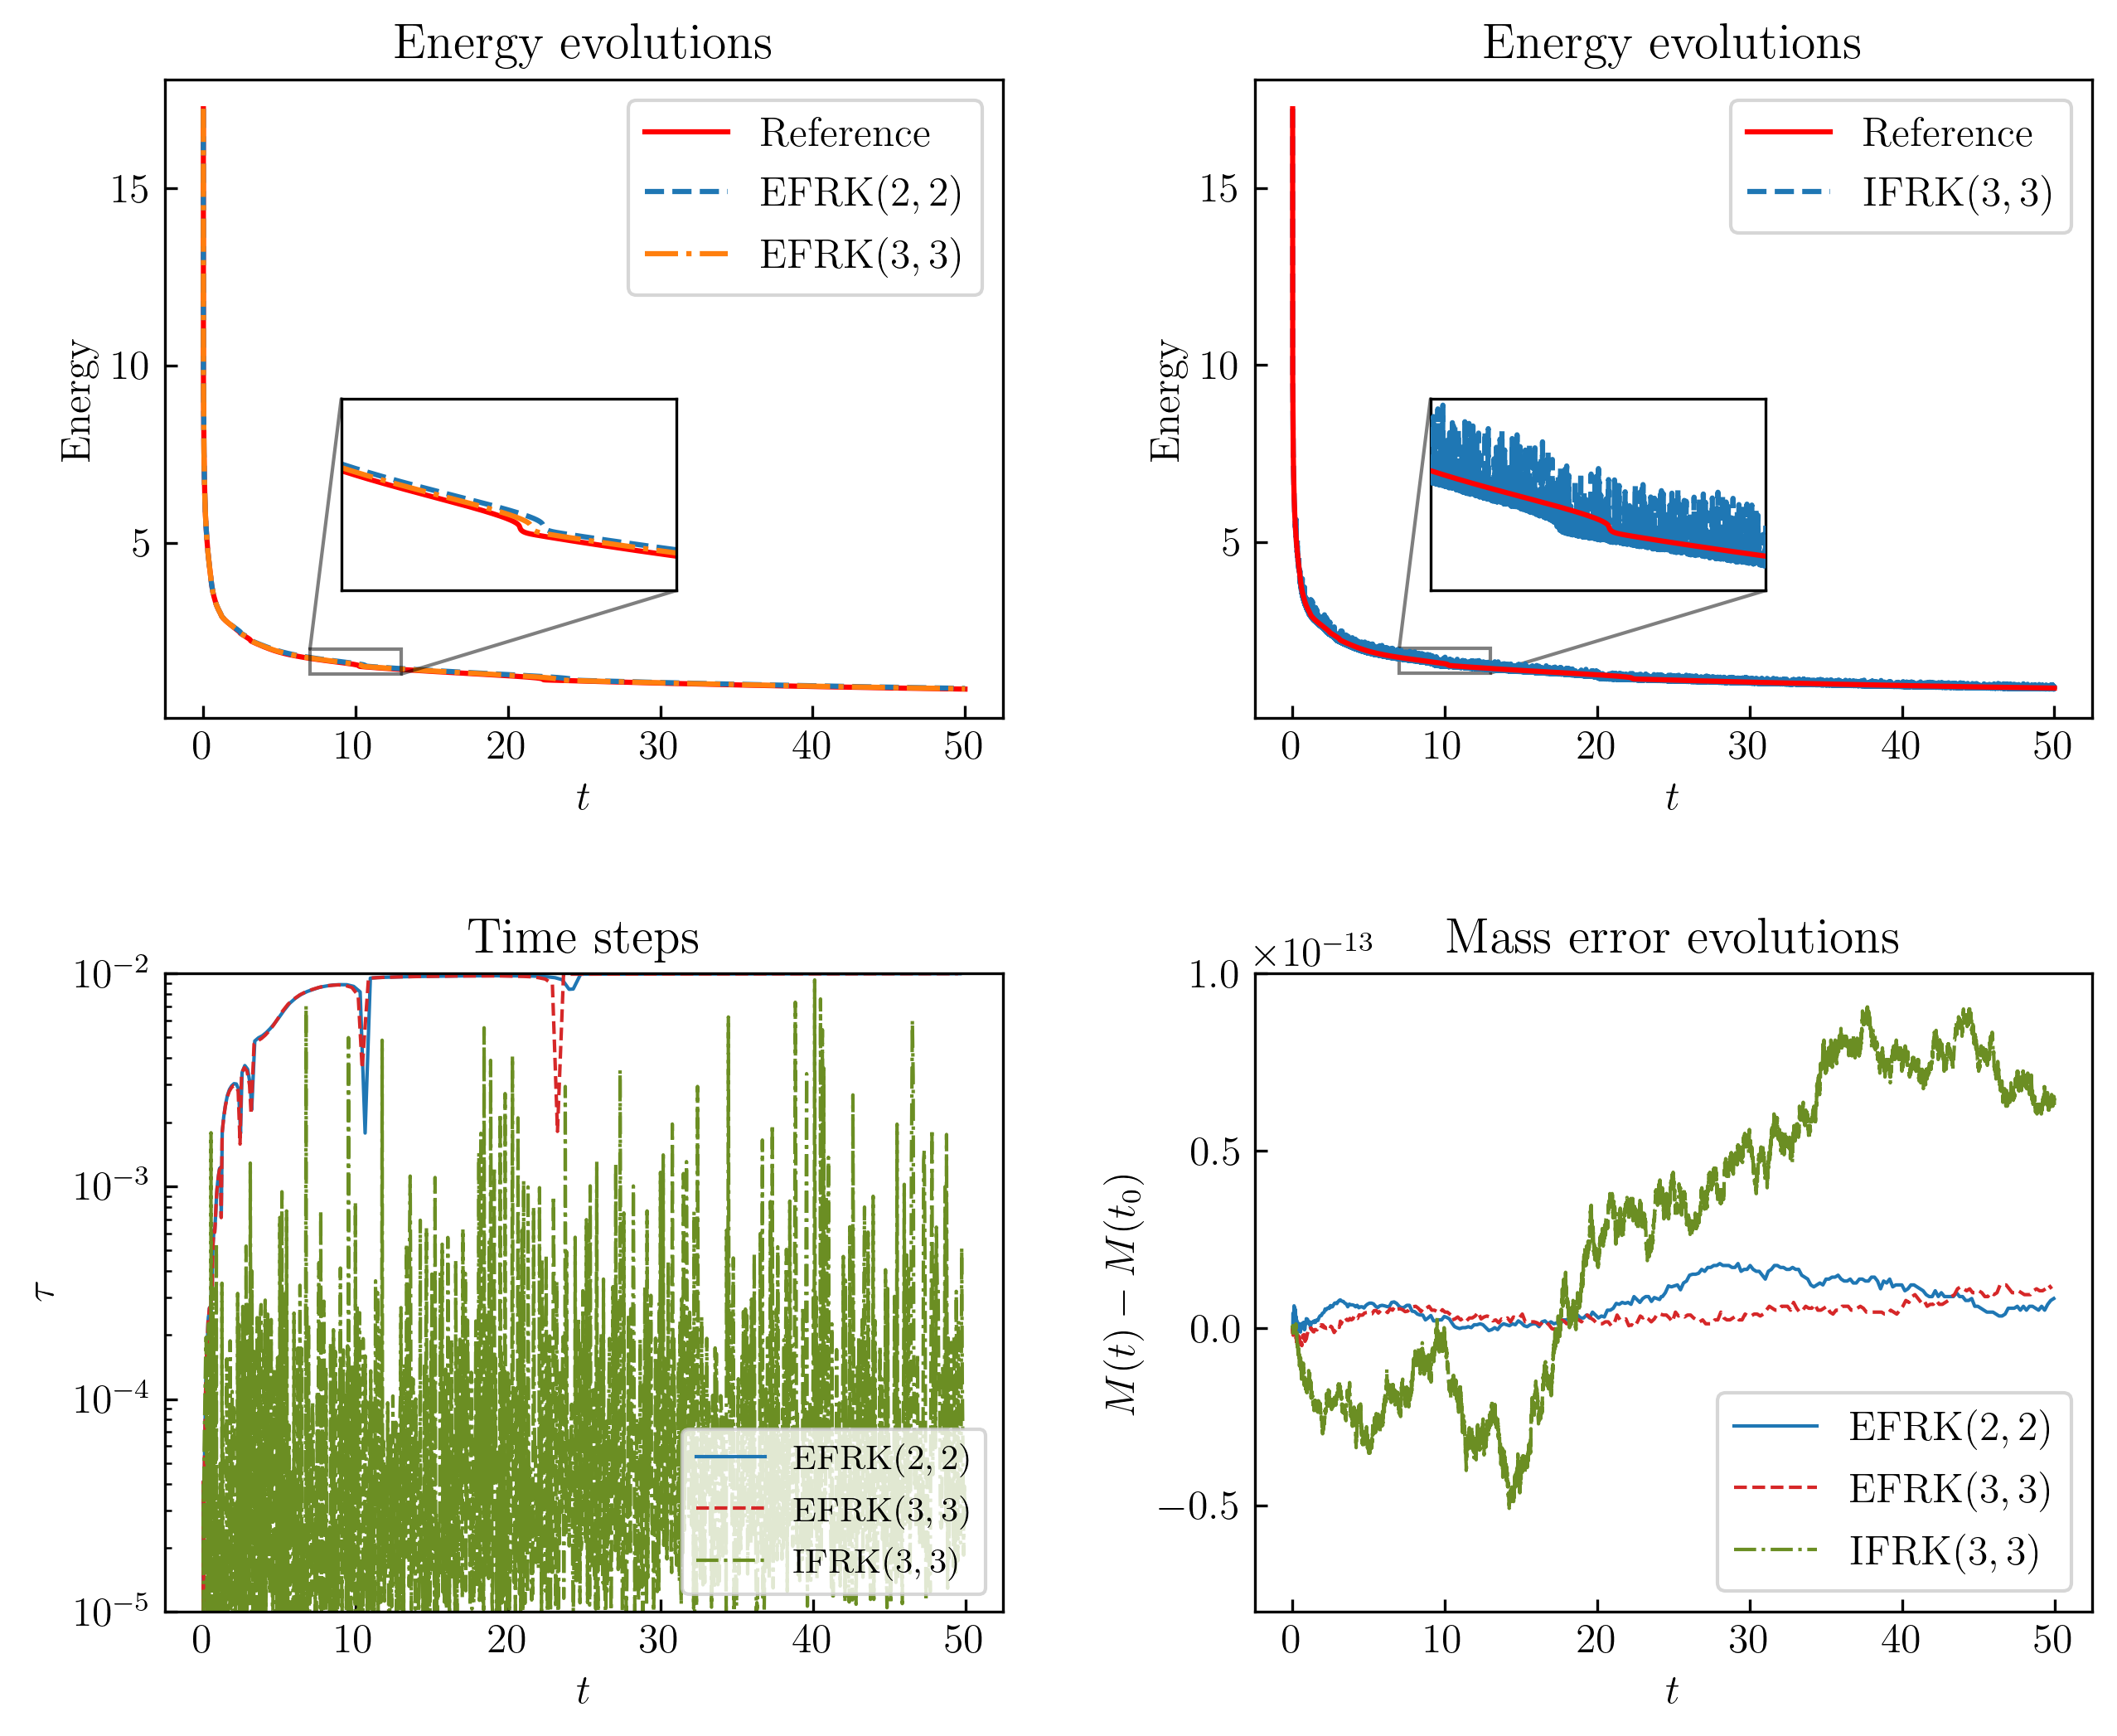

: 

In [13]:
fig = plt.figure(figsize=(10,8),dpi=300)
ax = plt.subplot(2,2,1)
ax.plot(CH_solver_ETDRK3_ref.tn,    CH_solver_ETDRK3_ref.En    ,"r-",label = r"Reference")
ax.plot(CH_solver_EFRK2_adaptive.tn,CH_solver_EFRK2_adaptive.En,"--" ,label = r"EFRK$(2,2)$")
ax.plot(CH_solver_EFRK3_adaptive.tn,CH_solver_EFRK3_adaptive.En,"-.",label = r"EFRK$(3,3)$") 
ax.set_title("Energy evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("Energy")
ax.legend(loc="upper right")

axins = ax.inset_axes([0.21,0.2,0.4,0.3])
axins.plot(CH_solver_ETDRK3_ref.tn,    CH_solver_ETDRK3_ref.En    ,"r-")
axins.plot(CH_solver_EFRK2_adaptive.tn,CH_solver_EFRK2_adaptive.En,"--" )
axins.plot(CH_solver_EFRK3_adaptive.tn,CH_solver_EFRK3_adaptive.En,"-.")
axins.set_xlim(7,13)
axins.set_ylim(1.3,2.)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(2,2,2)
ax.plot(CH_solver_ETDRK3_ref.tn,    CH_solver_ETDRK3_ref.En,"r-",label = r"Reference", zorder = 192)
ax.plot(CH_solver_IFRK3_adaptive.tn[::20],CH_solver_IFRK3_adaptive.En[::20],"--",label = r"IFRK$(3,3)$",zorder = 191)
ax.set_title("Energy evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("Energy")
ax.legend(loc="upper right")

axins = ax.inset_axes([0.21,0.2,0.4,0.3])
axins.plot(CH_solver_ETDRK3_ref.tn,    CH_solver_ETDRK3_ref.En,"r-",label = r"Reference",zorder = 202)
axins.plot(CH_solver_IFRK3_adaptive.tn[::10],CH_solver_IFRK3_adaptive.En[::10],"--",zorder = 201)
axins.set_xlim(7,13)
axins.set_ylim(1.3,2.)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = plt.subplot(2,2,3)
ax.plot(CH_solver_EFRK2_adaptive.tn[::50],CH_solver_EFRK2_adaptive.tau_list[::50],"-",color = "C0",linewidth = 1,label = r"EFRK$(2,2)$")
ax.plot(CH_solver_EFRK3_adaptive.tn[::50],CH_solver_EFRK3_adaptive.tau_list[::50],"--",color = "C3",linewidth = 1,label = r"EFRK$(3,3)$")
ax.plot(CH_solver_IFRK3_adaptive.tn[::200],CH_solver_IFRK3_adaptive.tau_list[::200],"-.",color = "olivedrab",linewidth = 1,label = r"IFRK$(3,3)$")
ax.set_title("Time steps")
ax.set_xlabel("$t$")
ax.set_yscale("log")
ax.set_ylabel(r"$\tau$")
ax.set_ylim(1e-5,1e-2)
ax.legend(loc = "lower right",fontsize = "small")

ax = plt.subplot(2,2,4)
ax.plot(CH_solver_EFRK2_adaptive.tn[::20],(CH_solver_EFRK2_adaptive.Mn - CH_solver_EFRK2_adaptive.Mn[0])[::20],"-",color = "C0",linewidth = 1,label = r"EFRK$(2,2)$")
ax.plot(CH_solver_EFRK3_adaptive.tn[::20],(CH_solver_EFRK3_adaptive.Mn - CH_solver_EFRK3_adaptive.Mn[0])[::20],"--",color = "C3",linewidth = 1,label = r"EFRK$(3,3)$")
ax.plot(CH_solver_IFRK3_adaptive.tn[::20],(CH_solver_IFRK3_adaptive.Mn - CH_solver_IFRK3_adaptive.Mn[0])[::20],"-.",color = "olivedrab",linewidth = 1,label = r"IFRK$(3,3)$")
ax.set_ylim(-0.8e-13,1e-13)
ax.set_title("Mass error evolutions")
ax.set_xlabel("$t$")
ax.set_ylabel("$M(t) - M(t_0)$")
ax.legend(loc="lower right")


plt.subplots_adjust(wspace=0.3,hspace=0.4)
fig.savefig("fig/dynamic_CH_property.pdf",dpi=600,bbox_inches="tight",pad_inches=0.2)